## Import libraries

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import keras
import requests
import os
import yaml
import random
from scipy.stats import chi2_contingency
import tensorflow
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error, root_mean_squared_error, accuracy_score
from itertools import product
from tqdm import tqdm
import pickle
from pathlib import Path
# Set the seed for random function of python
random.seed(1)

## Load Dataset

### Define paths

In [42]:
current_dir = os.getcwd()
project_root_path = Path(current_dir).resolve().parent.parent
statistics_path = os.path.join(project_root_path, "statistics")

### Import GDP stats

In [ ]:
with open(os.path.join(statistics_path, "gdpBinary.yaml"), "r") as f:
    gdpBinary = yaml.safe_load(f)
gdpBinary = gdpBinary["gdp_per_capita_index"]

with open(os.path.join(statistics_path, "gdp.yaml"), "r") as f:
    gdpRaw = yaml.safe_load(f)
gdpRaw = gdpRaw["gdp_per_capita_index"]

### Import Electricity Consumption stats

In [ ]:
os.path.join(statistics_path, "electricityConsumptionBinary.yaml")
with open(os.path.join(statistics_path, "electricityConsumption.yaml"), "r") as f:
    electricityConsumptionRaw = yaml.safe_load(f)
electricityConsumptionRaw = electricityConsumptionRaw["electricity_consumption_per_capita_index"]

with open(os.path.join(statistics_path, "electricityConsumptionBinary.yaml"), "r") as f:
    electricityConsumptionBinary = yaml.safe_load(f)
electricityConsumptionBinary = electricityConsumptionBinary["electricity_consumption_per_capita_index"]

### Import CO2 stats

In [ ]:
os.path.join(statistics_path, "carbonDioxideEmissionsProductionTonnesBinary.yaml")

with open(os.path.join(statistics_path, "carbonDioxideEmissionsProductionTonnes.yaml"), "r") as f:
    CO2Raw = yaml.safe_load(f)
CO2Raw = CO2Raw["carbon_dioxide_emissions_per_capita_production_tonnes"]

with open(os.path.join(statistics_path, "carbonDioxideEmissionsProductionTonnesBinary.yaml"), "r") as f:
    CO2Binary = yaml.safe_load(f)
CO2Binary = CO2Binary["carbon_dioxide_emissions_per_capita_production_tonnes_binary"]

In [ ]:
# unzip fetched dataset (need to mount Drive)
!unzip -q /content/drive/MyDrive/VIIRS/bagsAugmented.zip -d /content/

In [24]:
def createBags(statsBinary, statsRaw, startYear = 14):
    # load custom Bags dataset for training with Keras
    train_bags = []
    val_bags = []
    test_bags = []
    dataset_path = "C:\\Users\\nikch\\Documents\\coding\\SatSenseAI\\dataset\\bagsAugmented"
    # dataset_path = "/content/bagsAugmented"
    instances_count = 50
    train_bags_labels_binary = []
    train_bags_labels_raw = []
    val_bags_labels_binary = []
    val_bags_labels_raw = []
    test_bags_labels_binary = []
    test_bags_labels_raw = []
    countries = sorted(os.listdir(dataset_path))
    years = sorted(os.listdir(os.path.join(dataset_path, countries[0])))
    # remove b23 bag from years if exist (for consistency with latter results)
    # (when this notebook created b23 was not available)
    if startYear != 14:
        years.remove("b14")
    print(f"Countries: {countries}")
    print(f"Bags per year: {years}")
    train_countries = random.sample(countries, 12)
    for i, country in enumerate(countries):
        val_year = random.sample(years, 2)
        for year_bag in years:
            bag = []
            # Get the list of files
            all_files = os.listdir(os.path.join(dataset_path, country, year_bag))
            # Pick 30 random files without replacement
            selected_files = random.sample(all_files, instances_count)
            for img_path in selected_files:
                # Loads each image into PIL format
                img = keras.preprocessing.image.load_img(os.path.join(dataset_path, country, year_bag, img_path),
                                                        target_size=(300, 225),
                                                        color_mode="grayscale")
                # Converts a PIL Image instance to a NumPy array
                img_array = keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0  # standardize image to [0, 1]
                bag.append(img_array)
                if len(bag) == instances_count:
                    break
            # collect the corresponding gdp per capita index
            id = int(year_bag[1:]) - startYear
            if country in train_countries:
                if year_bag in val_year:
                    val_bags.append(bag)
                    val_bags_labels_binary.append([statsBinary[country][id]])
                    val_bags_labels_raw.append([statsRaw[country][id]])
                else:
                    train_bags.append(bag)
                    train_bags_labels_binary.append([statsBinary[country][id]])
                    train_bags_labels_raw.append([statsRaw[country][id]])
            else:
                test_bags.append(bag)
                test_bags_labels_binary.append([statsBinary[country][id]])
                test_bags_labels_raw.append([statsRaw[country][id]])
    train_bags = np.squeeze(np.swapaxes(np.array(train_bags), 0, 1))
    train_bags_labels_binary = np.array(train_bags_labels_binary)
    train_bags_labels_raw = np.array(train_bags_labels_raw)
    val_bags = np.squeeze(np.swapaxes(np.array(val_bags), 0, 1))
    val_bags_labels_binary = np.array(val_bags_labels_binary)
    val_bags_labels_raw = np.array(val_bags_labels_raw)
    test_bags = np.squeeze(np.swapaxes(np.array(test_bags), 0, 1))
    test_bags_labels_binary = np.array(test_bags_labels_binary)
    test_bags_labels_raw = np.array(test_bags_labels_raw)

    return train_bags, train_bags_labels_binary, train_bags_labels_raw, val_bags, val_bags_labels_binary, val_bags_labels_raw, test_bags, test_bags_labels_binary, test_bags_labels_raw

## Features Extraction

In [7]:
def extract_histogram(image, bins=64):
    hist, _ = np.histogram(image.flatten(), bins=bins)
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize
    return hist

In [8]:
def extract_bag_features(bag_images, bins=64, agg="mean"):
    histograms = [extract_histogram(img, bins) for img in bag_images]
    if agg == "mean":
        return np.mean(histograms, axis=0)
    elif agg == "max":
        return np.max(histograms, axis=0)
    elif agg == "concat":
        return np.concatenate(histograms)

In [9]:
def prepare_features(bags, labels, bins=64, agg="mean"):
    num_bags = bags.shape[1]
    X, y = [], []
    for i in range(num_bags):
        bag = bags[:, i, :, :]  # shape: (50, 300, 225)
        features = extract_bag_features(bag, bins, agg)
        X.append(features)
        y.append(labels[i][0])
    return np.array(X), np.array(y)

## Training

For our experiments we will try different number of histogram bins and different aggregation methods.

We will try:

- bins: [4, 8, 16, 32, 64]

- aggregation methods: ["mean", "max", "concat"]

At first we concatenate the training and validation sets that were used for the Neural Network Approaches into one single set. 

At first we train over this combined set on raw models without any fine tuning.

In [10]:
bins = [4, 8, 16, 32, 64]
aggregation_methods = ["mean", "max", "concat"]

In [11]:
rf_classification_grid = {
    "n_estimators": [50, 100, 150, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 3]
}

rf_regression_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 3]
}

dt_classification_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 3]
}

dt_regression_grid = {
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 3]
}

lt_classification_grid = {
    "C": [0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

lt_regression_grid = {
    "C": [0.1, 1, 10],
}

This function performs classification using three models (Random Forest, Decision Tree, Linear SVC) across combinations of binning and aggregation methods for feature extraction.

Key Steps:
- Loop through all combinations of bins and aggregation_methods.

- Generate features for training, validation, and test sets using prepare_features(...).

- Concatenate train and validation sets to perform model training and hyperparameter tuning via GridSearchCV.

- Train and evaluate each of the three classifiers on the test set:

        - RandomForestClassifier

        - DecisionTreeClassifier

        - LinearSVC

Store features and predictions for each combination in global dictionaries: features_dict and predictions_dict.

In [12]:
def classification(train_bags, train_bags_labels, val_bags, val_bags_labels, test_bags, test_bags_labels, rf_grid, dt_grid, lt_grid ,output_dir):
    # Store features and predictions
    features_dict = {}
    predictions_dict = {}
    
    for bin, aggregation_method in tqdm(product(bins, aggregation_methods), total=len(bins)*len(aggregation_methods), desc="Processing combinations"):
        key = f"bin_{bin}-aggregationFunction_{aggregation_method}"
        X_train, y_train = prepare_features(train_bags, train_bags_labels, bins=bin, agg=aggregation_method)
        X_val, y_val = prepare_features(val_bags, val_bags_labels, bins=bin, agg=aggregation_method)
        X_test, y_test = prepare_features(test_bags, test_bags_labels, bins=bin, agg=aggregation_method)

        # Save features
        features_dict[key] = {
            "X_train": X_train,
            "y_train": y_train,
            "X_val": X_val,
            "y_val": y_val,
            "X_test": X_test,
            "y_test": y_test,
        }

        X_combined = np.concatenate([X_train, X_val])
        y_combined = np.concatenate([y_train, y_val])

        # Grid search for random forest
        rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_grid, cv=5, scoring='accuracy')
        rf_grid_search.fit(X_combined, y_combined)
        rf_model = rf_grid_search.best_estimator_.fit(X_combined, y_combined)
        rf_predictions = rf_model.predict(X_test)

        # Grid search for decision tree
        dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_grid, cv=5, scoring='accuracy')
        dt_grid_search.fit(X_combined, y_combined)
        dt_model = dt_grid_search.best_estimator_.fit(X_combined, y_combined)
        dt_predictions = dt_model.predict(X_test)

        # Grid search for linear model
        lm_grid_search = GridSearchCV(LinearSVC(), lt_grid, cv=5, scoring='accuracy')
        lm_grid_search.fit(X_combined, y_combined)
        lm_model = lm_grid_search.best_estimator_.fit(X_combined, y_combined)
        svc_predictions = lm_model.predict(X_test)      

        # Save predictions
        predictions_dict[key] = {
            "RandomForest": {
                "predictions": rf_predictions,
                "model": rf_model  # Optional: include the model object
            },
            "LinearSVC": {
                "predictions": svc_predictions,
                "model": lm_model  # Optional: include the model object
            },
            "DecisionTree": {
                "predictions": dt_predictions,
                "model": dt_model  # Optional: include the model object
            }
        }

    os.makedirs(output_dir, exist_ok=True)

    # Save features_dict
    with open(os.path.join(output_dir, "features_dict.pkl"), "wb") as f:
        pickle.dump(features_dict, f)

    # Save predictions_dict
    with open(os.path.join(output_dir, "predictions_dict.pkl"), "wb") as f:
        pickle.dump(predictions_dict, f)

In [13]:
def regression(train_bags, train_bags_labels, val_bags, val_bags_labels, test_bags, test_bags_labels, rf_grid, dt_grid, lt_grid, output_dir):
    # Store features and predictions
    features_dict = {}
    predictions_dict = {}
    
    for bin, aggregation_method in tqdm(product(bins, aggregation_methods), total=len(bins)*len(aggregation_methods), desc="Processing combinations"):
        key = f"bin_{bin}-aggregationFunction_{aggregation_method}"
        X_train, y_train = prepare_features(train_bags, train_bags_labels, bins=bin, agg=aggregation_method)
        X_val, y_val = prepare_features(val_bags, val_bags_labels, bins=bin, agg=aggregation_method)
        X_test, y_test = prepare_features(test_bags, test_bags_labels, bins=bin, agg=aggregation_method)

        # Save features
        features_dict[key] = {
            "X_train": X_train,
            "y_train": y_train,
            "X_val": X_val,
            "y_val": y_val,
            "X_test": X_test,
            "y_test": y_test,
        }

        X_combined = np.concatenate([X_train, X_val])
        y_combined = np.concatenate([y_train, y_val])

        # Grid search for random forest
        rf_grid_search = GridSearchCV(RandomForestRegressor(), rf_grid, cv=5, scoring='neg_root_mean_squared_error')
        rf_grid_search.fit(X_combined, y_combined)
        rf_model = rf_grid_search.best_estimator_.fit(X_combined, y_combined)
        rf_predictions = rf_model.predict(X_test)

        # Grid search for decision tree
        dt_grid_search = GridSearchCV(DecisionTreeRegressor(), dt_grid, cv=5, scoring='neg_root_mean_squared_error')
        dt_grid_search.fit(X_combined, y_combined)
        dt_model = dt_grid_search.best_estimator_.fit(X_combined, y_combined)
        dt_predictions = dt_model.predict(X_test)

        # Grid search for linear model
        lm_grid_search = GridSearchCV(LinearSVR(), lt_grid, cv=5, scoring='accuracy')
        lm_grid_search.fit(X_combined, y_combined)
        lm_model = lm_grid_search.best_estimator_.fit(X_combined, y_combined)
        svc_predictions = lm_model.predict(X_test)      

        # Save predictions
        predictions_dict[key] = {
            "RandomForest": {
                "predictions": rf_predictions,
                "model": rf_model  # Optional: include the model object
            },
            "LinearSVR": {
                "predictions": svc_predictions,
                "model": lm_model  # Optional: include the model object
            },
            "DecisionTree": {
                "predictions": dt_predictions,
                "model": dt_model  # Optional: include the model object
            }
        }

    os.makedirs(output_dir, exist_ok=True)

    # Save features_dict
    with open(os.path.join(output_dir, "features_dict.pkl"), "wb") as f:
        pickle.dump(features_dict, f)

    # Save predictions_dict
    with open(os.path.join(output_dir, "predictions_dict.pkl"), "wb") as f:
        pickle.dump(predictions_dict, f)

### GDP

In [126]:
random.seed(1)

In [127]:
train_bags, train_bags_labels_binary, train_bags_labels_raw, val_bags, val_bags_labels_binary, val_bags_labels_raw, test_bags, test_bags_labels_binary, test_bags_labels_raw = createBags(gdbBinary, gdbRaw)

Countries: ['Albania', 'Austria', 'Belgium', 'Bosnia', 'Bulgaria', 'England', 'FYROM', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Spain']
Bags per year: ['b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23']


In [128]:
print("~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~")
print(f"Bags Shape: {train_bags.shape}")
print(f"Number of Bags: {train_bags.shape[1]}")
print(f"Number of Instances per Bag: {train_bags.shape[0]}")
print(f"Shape of each Instance: {train_bags.shape[2:]}")
print(f"Shape of Labels: {train_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~")
print(f"Bags Shape: {val_bags.shape}")
print(f"Number of Bags: {val_bags.shape[1]}")
print(f"Number of Instances per Bag: {val_bags.shape[0]}")
print(f"Shape of each Instance: {val_bags.shape[2:]}")
print(f"Shape of Labels: {val_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~")
print(f"Bags Shape: {test_bags.shape}")
print(f"Number of Bags: {test_bags.shape[1]}")
print(f"Number of Instances per Bag: {test_bags.shape[0]}")
print(f"Shape of each Instance: {test_bags.shape[2:]}")
print(f"Shape of Labels: {test_bags_labels_binary.shape}")
train_bags = list(train_bags)
val_bags = list(val_bags)
test_bags = list(test_bags)

~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~
Bags Shape: (50, 96, 300, 225)
Number of Bags: 96
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (96, 1)
~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~
Bags Shape: (50, 24, 300, 225)
Number of Bags: 24
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (24, 1)
~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~
Bags Shape: (50, 70, 300, 225)
Number of Bags: 70
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (70, 1)


In [129]:
print(f"Positive / Negative Bags in train set: {np.sum(train_bags_labels_binary)} / {train_bags_labels_binary.shape[0] - np.sum(train_bags_labels_binary)}")
print(f"Positive / Negative Bags in validation set: {np.sum(val_bags_labels_binary)} / {val_bags_labels_binary.shape[0] - np.sum(val_bags_labels_binary)}")
print(f"Positive / Negative Bags in test set: {np.sum(test_bags_labels_binary)} / {test_bags_labels_binary.shape[0] - np.sum(test_bags_labels_binary)}")

Positive / Negative Bags in train set: 61 / 35
Positive / Negative Bags in validation set: 14 / 10
Positive / Negative Bags in test set: 35 / 35


#### GDP Classification

In [27]:
np_train_bags = np.array(train_bags)
np_train_bags_labels = np.array(train_bags_labels_binary)

np_val_bags = np.array(val_bags)
np_val_bags_labels = np.array(val_bags_labels_binary)

np_test_bags = np.array(test_bags)
np_test_bags_labels = np.array(test_bags_labels_binary)

In [ ]:
# Create output directory
output_dir = os.path.join("gdp", "classification")

In [ ]:
classification(np_train_bags, np_train_bags_labels, np_val_bags, np_val_bags_labels, np_test_bags, np_test_bags_labels, rf_classification_grid, dt_classification_grid, lt_classification_grid, output_dir)

Processing combinations:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Processing combinations:   7%|▋         | 1/15 [00:32<07:28, 32.00s/it]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\

#### GDP Regression

In [130]:
np_train_bags = np.array(train_bags)
np_train_bags_labels = np.array(train_bags_labels_raw)

np_val_bags = np.array(val_bags)
np_val_bags_labels = np.array(val_bags_labels_raw)

np_test_bags = np.array(test_bags)
np_test_bags_labels = np.array(test_bags_labels_raw)

In [ ]:
# Create output directory
output_dir = os.path.join("gdp", "regression")

In [132]:
regression(np_train_bags, np_train_bags_labels, np_val_bags, np_val_bags_labels, np_test_bags, np_test_bags_labels, rf_regression_grid, dt_regression_grid, lt_regression_grid, output_dir)

Processing combinations:   0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(

### Energy consumption

In [66]:
random.seed(2)

In [67]:
train_bags, train_bags_labels_binary, train_bags_labels_raw, val_bags, val_bags_labels_binary, val_bags_labels_raw, test_bags, test_bags_labels_binary, test_bags_labels_raw = createBags(electricityConsumptionBinary, electricityConsumptionRaw, 15)

Countries: ['Albania', 'Austria', 'Belgium', 'Bosnia', 'Bulgaria', 'England', 'FYROM', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Spain']
Bags per year: ['b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23']


In [68]:
print("~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~")
print(f"Bags Shape: {train_bags.shape}")
print(f"Number of Bags: {train_bags.shape[1]}")
print(f"Number of Instances per Bag: {train_bags.shape[0]}")
print(f"Shape of each Instance: {train_bags.shape[2:]}")
print(f"Shape of Labels: {train_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~")
print(f"Bags Shape: {val_bags.shape}")
print(f"Number of Bags: {val_bags.shape[1]}")
print(f"Number of Instances per Bag: {val_bags.shape[0]}")
print(f"Shape of each Instance: {val_bags.shape[2:]}")
print(f"Shape of Labels: {val_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~")
print(f"Bags Shape: {test_bags.shape}")
print(f"Number of Bags: {test_bags.shape[1]}")
print(f"Number of Instances per Bag: {test_bags.shape[0]}")
print(f"Shape of each Instance: {test_bags.shape[2:]}")
print(f"Shape of Labels: {test_bags_labels_binary.shape}")
train_bags = list(train_bags)
val_bags = list(val_bags)
test_bags = list(test_bags)

~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~
Bags Shape: (50, 84, 300, 225)
Number of Bags: 84
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (84, 1)
~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~
Bags Shape: (50, 24, 300, 225)
Number of Bags: 24
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (24, 1)
~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~
Bags Shape: (50, 63, 300, 225)
Number of Bags: 63
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (63, 1)


In [69]:
print(f"Positive / Negative Bags in train set: {np.sum(train_bags_labels_binary)} / {train_bags_labels_binary.shape[0] - np.sum(train_bags_labels_binary)}")
print(f"Positive / Negative Bags in validation set: {np.sum(val_bags_labels_binary)} / {val_bags_labels_binary.shape[0] - np.sum(val_bags_labels_binary)}")
print(f"Positive / Negative Bags in test set: {np.sum(test_bags_labels_binary)} / {test_bags_labels_binary.shape[0] - np.sum(test_bags_labels_binary)}")

Positive / Negative Bags in train set: 21 / 63
Positive / Negative Bags in validation set: 6 / 18
Positive / Negative Bags in test set: 18 / 45


#### Energy Consumption Classification

In [70]:
np_train_bags = np.array(train_bags)
np_train_bags_labels = np.array(train_bags_labels_binary)

np_val_bags = np.array(val_bags)
np_val_bags_labels = np.array(val_bags_labels_binary)

np_test_bags = np.array(test_bags)
np_test_bags_labels = np.array(test_bags_labels_binary)

In [71]:
# Create output directory
output_dir = os.path.join("energy_consumption", "classification")

In [72]:
classification(np_train_bags, np_train_bags_labels, np_val_bags, np_val_bags_labels, np_test_bags, np_test_bags_labels, rf_classification_grid, dt_classification_grid, lt_classification_grid, output_dir)

Processing combinations:   7%|▋         | 1/15 [00:33<07:55, 33.98s/it]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed

#### Enery Consumption Regression

In [73]:
np_train_bags = np.array(train_bags)
np_train_bags_labels = np.array(train_bags_labels_raw)

np_val_bags = np.array(val_bags)
np_val_bags_labels = np.array(val_bags_labels_raw)

np_test_bags = np.array(test_bags)
np_test_bags_labels = np.array(test_bags_labels_raw)

In [74]:
# Create output directory
output_dir = os.path.join("energy_consumption", "regression")

In [75]:
regression(np_train_bags, np_train_bags_labels, np_val_bags, np_val_bags_labels, np_test_bags, np_test_bags_labels, rf_regression_grid, dt_regression_grid, lt_regression_grid, output_dir)

Processing combinations:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\metrics\_scorer.py"

### CO2 Emissions

In [15]:
random.seed(1)

In [25]:
train_bags, train_bags_labels_binary, train_bags_labels_raw, val_bags, val_bags_labels_binary, val_bags_labels_raw, test_bags, test_bags_labels_binary, test_bags_labels_raw = createBags(CO2Binary, CO2Raw)

Countries: ['Albania', 'Austria', 'Belgium', 'Bosnia', 'Bulgaria', 'England', 'FYROM', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Spain']
Bags per year: ['b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23']


In [26]:
print("~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~")
print(f"Bags Shape: {train_bags.shape}")
print(f"Number of Bags: {train_bags.shape[1]}")
print(f"Number of Instances per Bag: {train_bags.shape[0]}")
print(f"Shape of each Instance: {train_bags.shape[2:]}")
print(f"Shape of Labels: {train_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~")
print(f"Bags Shape: {val_bags.shape}")
print(f"Number of Bags: {val_bags.shape[1]}")
print(f"Number of Instances per Bag: {val_bags.shape[0]}")
print(f"Shape of each Instance: {val_bags.shape[2:]}")
print(f"Shape of Labels: {val_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~")
print(f"Bags Shape: {test_bags.shape}")
print(f"Number of Bags: {test_bags.shape[1]}")
print(f"Number of Instances per Bag: {test_bags.shape[0]}")
print(f"Shape of each Instance: {test_bags.shape[2:]}")
print(f"Shape of Labels: {test_bags_labels_binary.shape}")
train_bags = list(train_bags)
val_bags = list(val_bags)
test_bags = list(test_bags)

~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~
Bags Shape: (50, 96, 300, 225)
Number of Bags: 96
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (96, 1)
~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~
Bags Shape: (50, 24, 300, 225)
Number of Bags: 24
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (24, 1)
~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~
Bags Shape: (50, 70, 300, 225)
Number of Bags: 70
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (70, 1)


In [27]:
print(f"Positive / Negative Bags in train set: {np.sum(train_bags_labels_binary)} / {train_bags_labels_binary.shape[0] - np.sum(train_bags_labels_binary)}")
print(f"Positive / Negative Bags in validation set: {np.sum(val_bags_labels_binary)} / {val_bags_labels_binary.shape[0] - np.sum(val_bags_labels_binary)}")
print(f"Positive / Negative Bags in test set: {np.sum(test_bags_labels_binary)} / {test_bags_labels_binary.shape[0] - np.sum(test_bags_labels_binary)}")

Positive / Negative Bags in train set: 66 / 30
Positive / Negative Bags in validation set: 17 / 7
Positive / Negative Bags in test set: 39 / 31


#### CO2 Emissions Classification

In [28]:
np_train_bags = np.array(train_bags)
np_train_bags_labels = np.array(train_bags_labels_binary)

np_val_bags = np.array(val_bags)
np_val_bags_labels = np.array(val_bags_labels_binary)

np_test_bags = np.array(test_bags)
np_test_bags_labels = np.array(test_bags_labels_binary)

In [29]:
# Create output directory
output_dir = os.path.join("CO2", "classification")

In [30]:
classification(np_train_bags, np_train_bags_labels, np_val_bags, np_val_bags_labels, np_test_bags, np_test_bags_labels, rf_classification_grid, dt_classification_grid, lt_classification_grid, output_dir)

Processing combinations:  13%|█▎        | 2/15 [01:05<07:04, 32.65s/it]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed

#### C02 Emissions Regression

In [36]:
np_train_bags = np.array(train_bags)
np_train_bags_labels = np.array(train_bags_labels_raw)

np_val_bags = np.array(val_bags)
np_val_bags_labels = np.array(val_bags_labels_raw)

np_test_bags = np.array(test_bags)
np_test_bags_labels = np.array(test_bags_labels_raw)

In [37]:
# Create output directory
output_dir = os.path.join("CO2", "regression")

In [38]:
regression(np_train_bags, np_train_bags_labels, np_val_bags, np_val_bags_labels, np_test_bags, np_test_bags_labels, rf_regression_grid, dt_regression_grid, lt_regression_grid, output_dir)

Processing combinations:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\metrics\_scorer.py"

## Show results

### Create plots

In [31]:
def compute_metrics(predictions_dict, features_dict, type):
    mae = {}
    rmse = {}
    accuracy = {}
    for key in predictions_dict:
        mae[key] = {}
        rmse[key] = {}
        accuracy[key] = {}
        
        for model_name, model_data in predictions_dict[key].items():
            y_pred = model_data["predictions"]
            y_true = features_dict[key]["y_test"]

            if type == "classification":
                accuracy[key][model_name] = accuracy_score(y_true, y_pred)*100
            else:
                mae[key][model_name] = mean_absolute_error(y_true, y_pred)
                rmse[key][model_name] = root_mean_squared_error(y_true, y_pred)
    
    return mae, rmse, accuracy

In [58]:
def plot(metric, metric_name, models):
    # Example inputs (replace with your real values)
    bins = [4, 8, 16, 32, 64]
    aggregation_methods = ["mean", "max", "concat"]

    # Loop over models and generate one plot per model
    for model in models:
        # Extract accuracy for this model grouped by aggregation method
        metric_by_agg = {
            agg: [
                metric[f"bin_{b}-aggregationFunction_{agg}"][model]
                for b in bins
            ]
            for agg in aggregation_methods
        }

        # Plot settings
        bar_width = 0.25
        x = np.arange(len(bins))  # base x positions

        plt.figure(figsize=(12, 8))

        for i, agg in enumerate(aggregation_methods):
            bar_positions = x + i * bar_width
            metrics = metric_by_agg[agg]
            bars = plt.bar(bar_positions, metrics, width=bar_width, label=agg)
            
            # Add accuracy labels above bars
            for pos, acc in zip(bar_positions, metrics):
                plt.text(pos, acc + 0.5, f"{acc:.1f}", ha='center', va='bottom', fontsize=9)

        # Formatting
        plt.xticks(x + bar_width, bins)
        plt.xlabel("Bin Size")
        plt.ylabel(f"{metric_name}")
        plt.title(f"{model} {metric_name} by Bin Size and Aggregation Function")
        plt.legend(title="Aggregation Method", loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()

#### GDP Binary

In [60]:
with open(os.path.join(current_dir, "gdp\\classification\\predictions_dict.pkl"), "rb") as f:
    predicitons_dict = pickle.load(f)

with open(os.path.join(current_dir, "gdp\\classification\\features_dict.pkl"), "rb") as f:
    features_dict = pickle.load(f)

In [61]:
_, _, accuracy = compute_metrics(predicitons_dict, features_dict, "classification", )

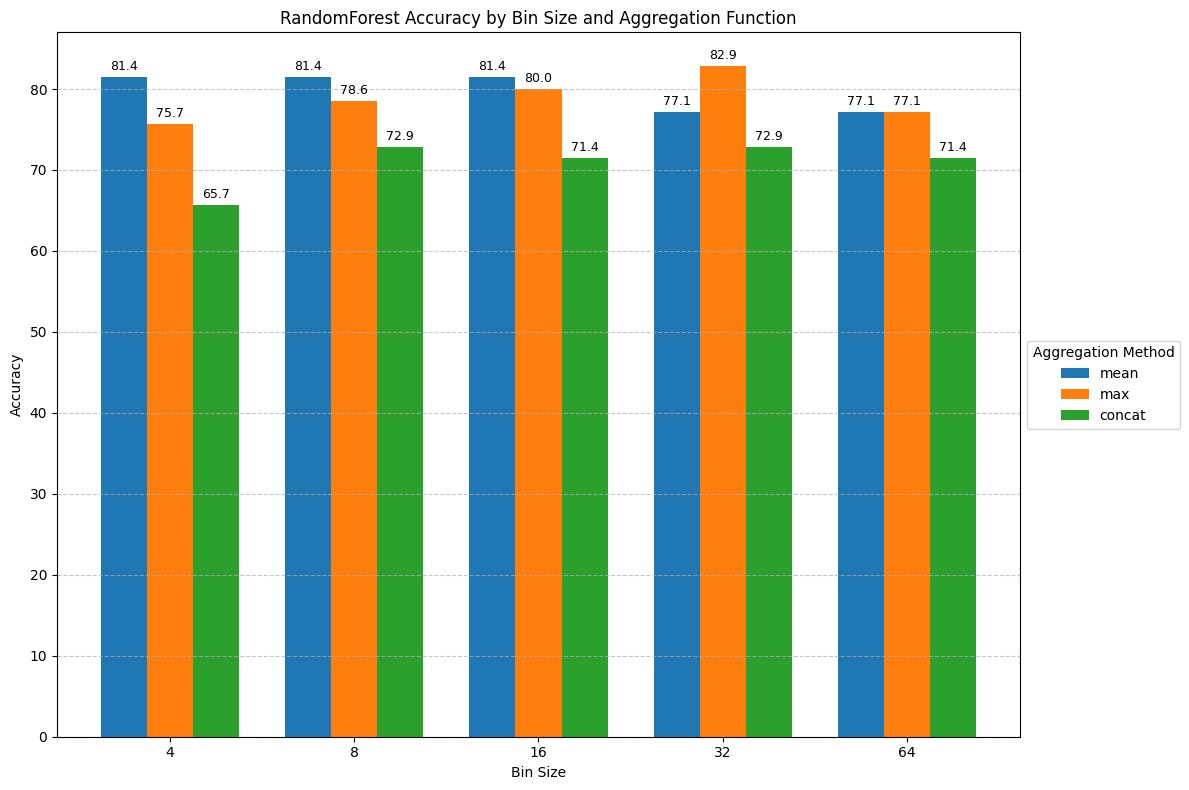

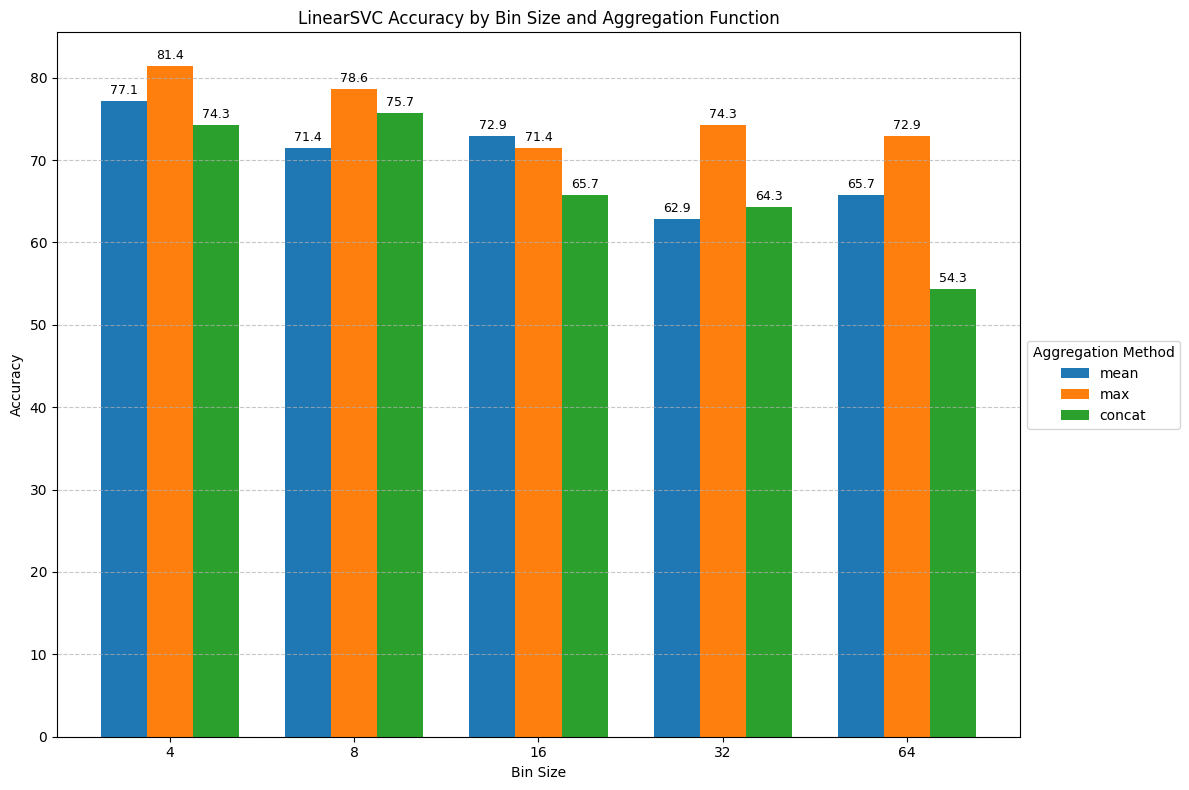

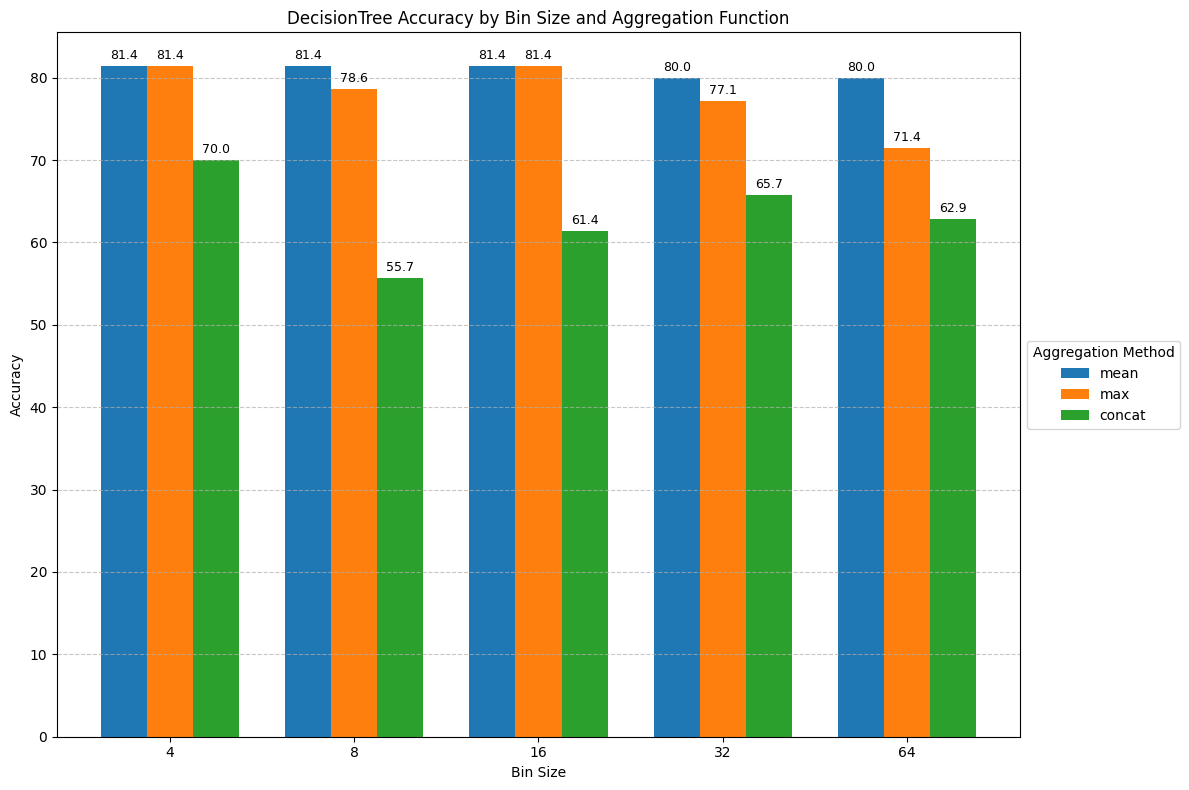

In [62]:
plot(accuracy, "Accuracy", ["RandomForest", "LinearSVC", "DecisionTree"])

#### GDP Raw

In [63]:
with open(os.path.join(current_dir, "gdp\\regression\\predictions_dict.pkl"), "rb") as f:
    predicitons_dict = pickle.load(f)

with open(os.path.join(current_dir, "gdp\\regression\\features_dict.pkl"), "rb") as f:
    features_dict = pickle.load(f)

In [64]:
mae, rmse, _ = compute_metrics(predicitons_dict, features_dict, "regression")

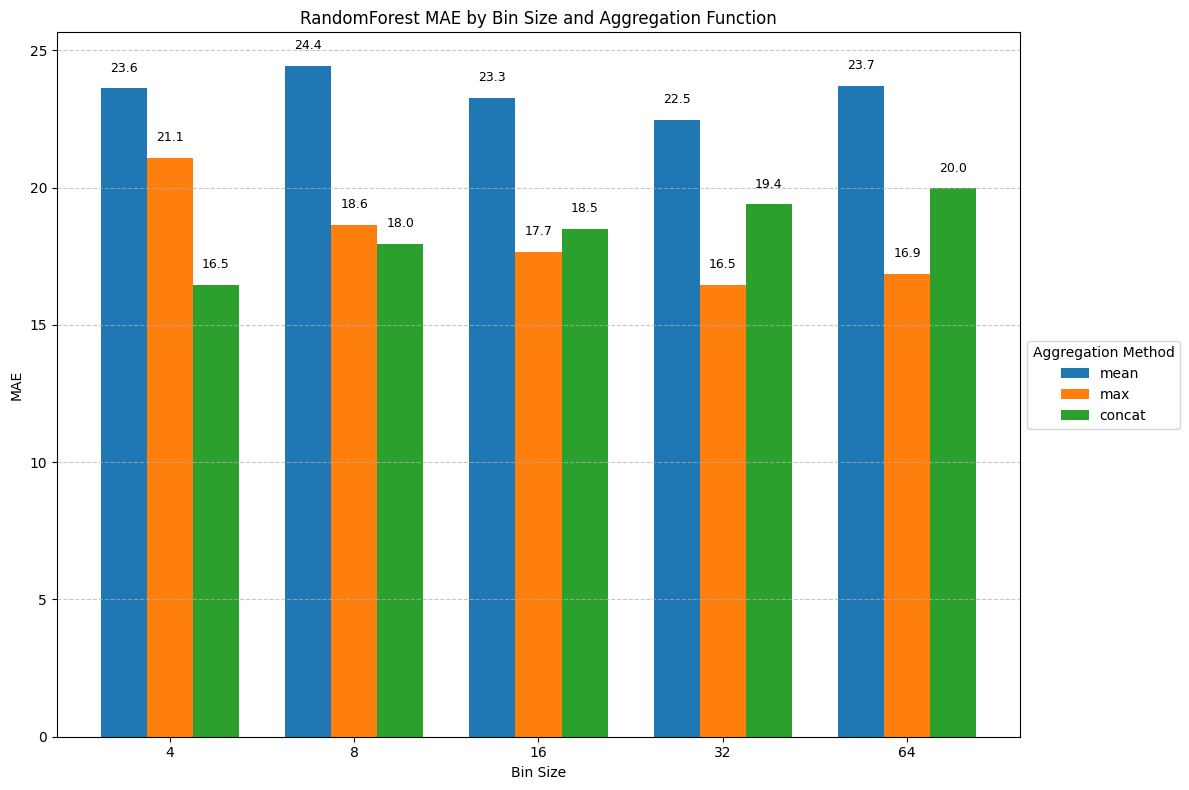

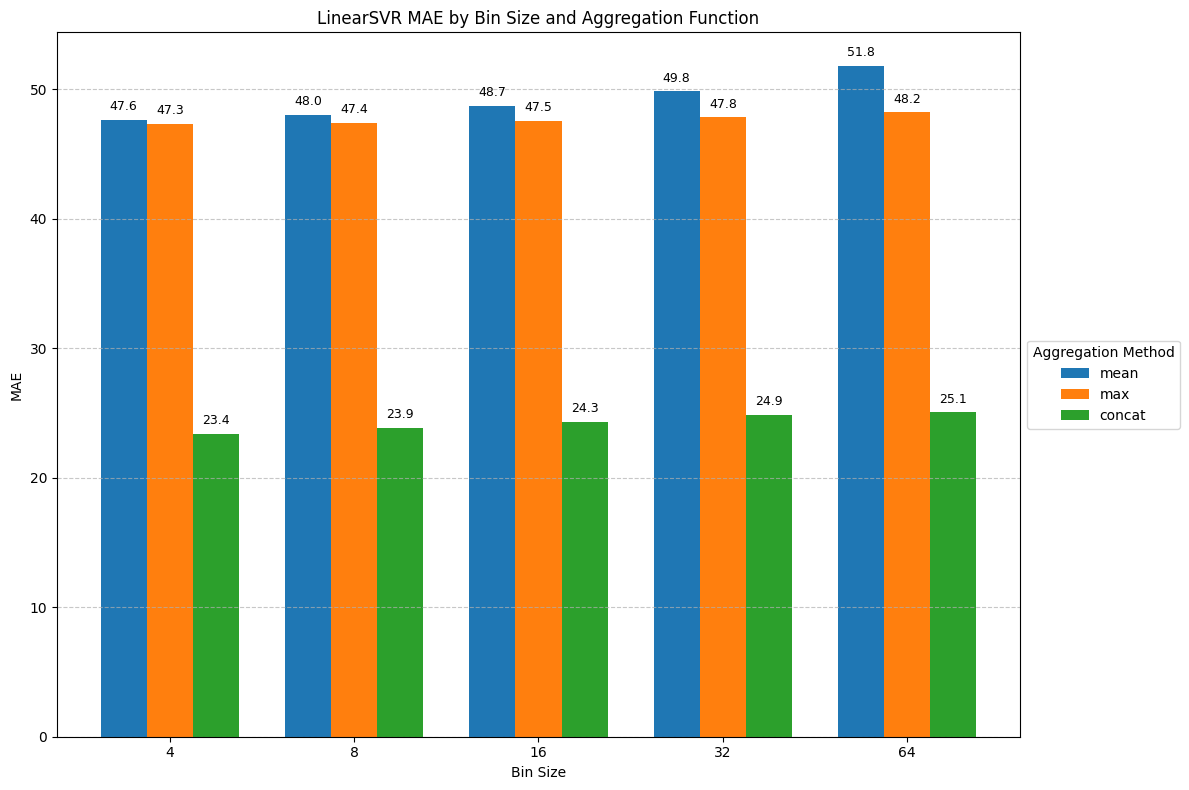

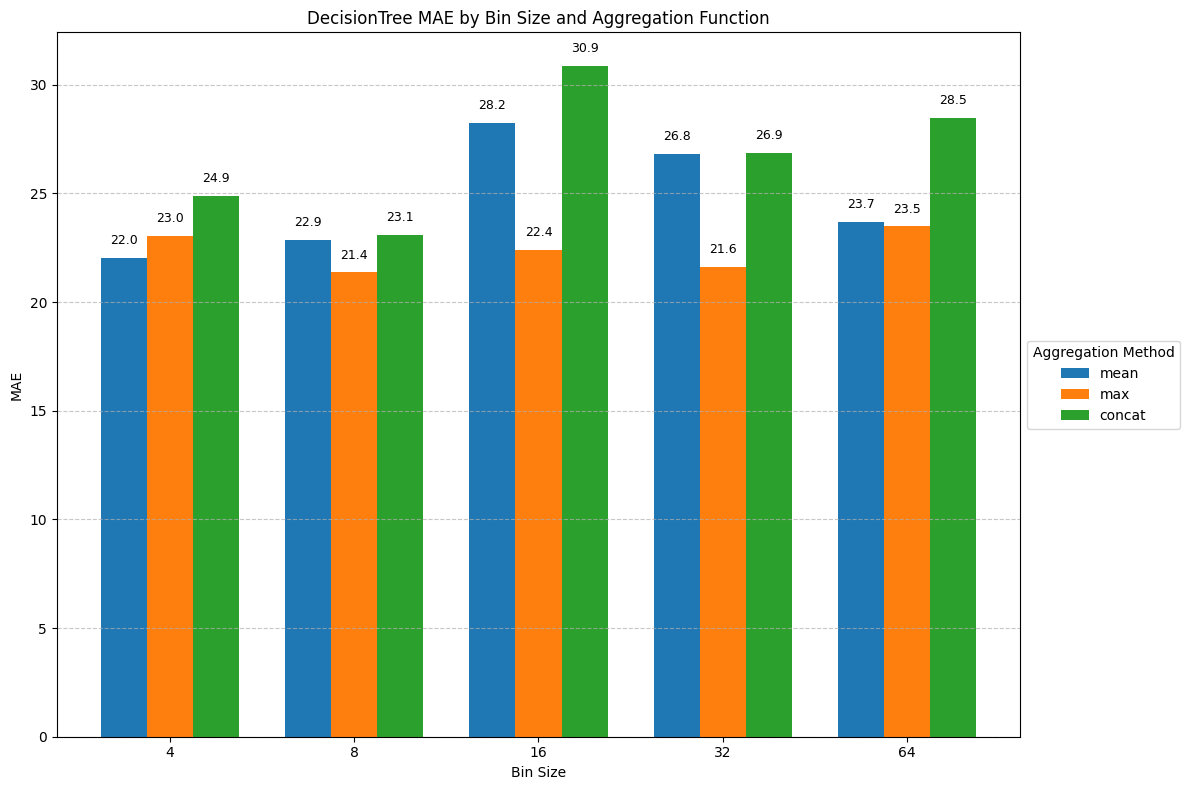

In [65]:
plot(mae, "MAE", ["RandomForest", "LinearSVR", "DecisionTree"])

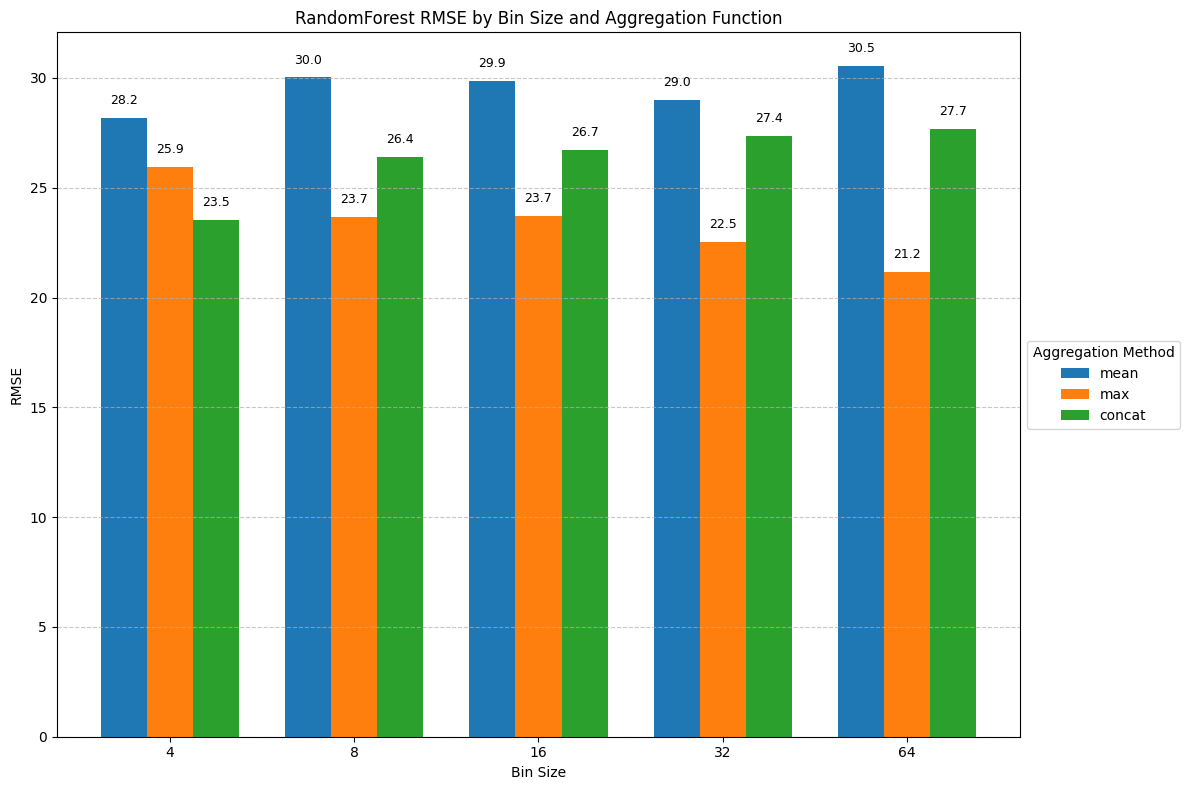

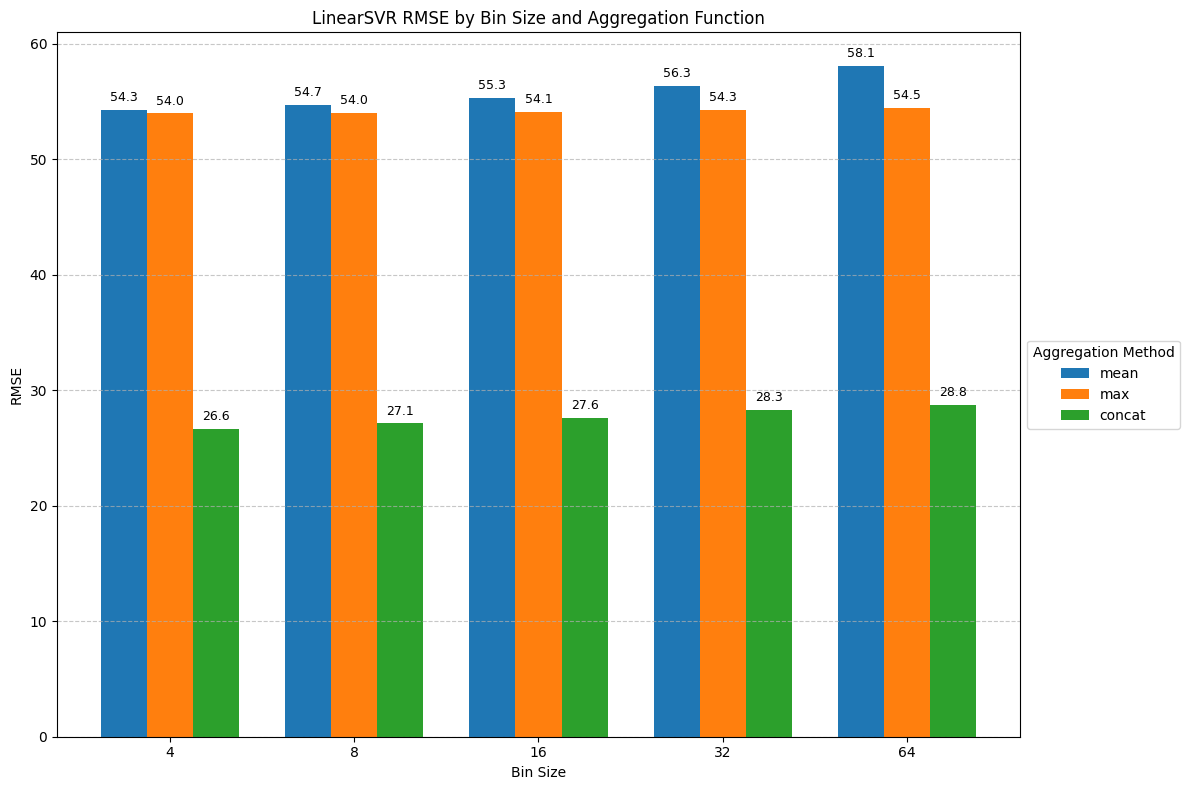

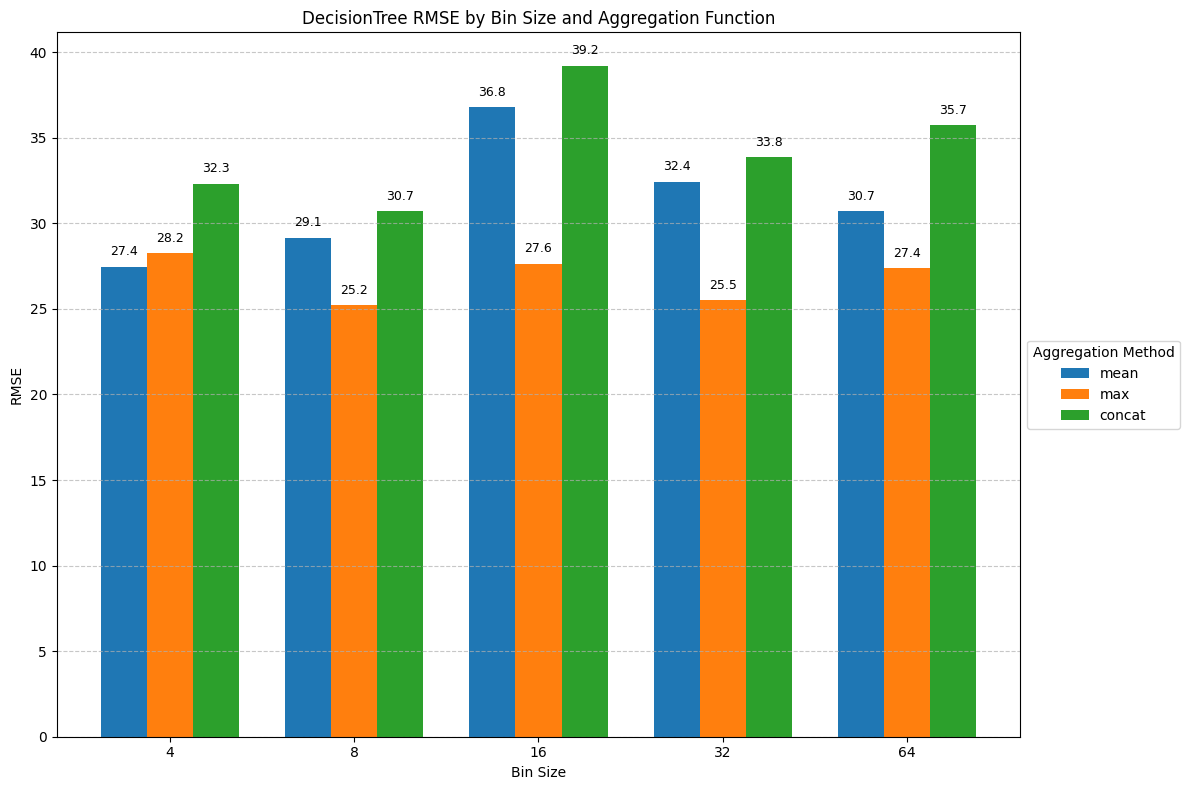

In [66]:
plot(rmse, "RMSE", ["RandomForest", "LinearSVR", "DecisionTree"])

#### Energy consumption Binary

In [67]:
with open(os.path.join(current_dir, "energy_consumption\\classification\\predictions_dict.pkl"), "rb") as f:
    predicitons_dict = pickle.load(f)

with open(os.path.join(current_dir, "energy_consumption\\classification\\features_dict.pkl"), "rb") as f:
    features_dict = pickle.load(f)

In [68]:
_, _, accuracy = compute_metrics(predicitons_dict, features_dict, "classification")

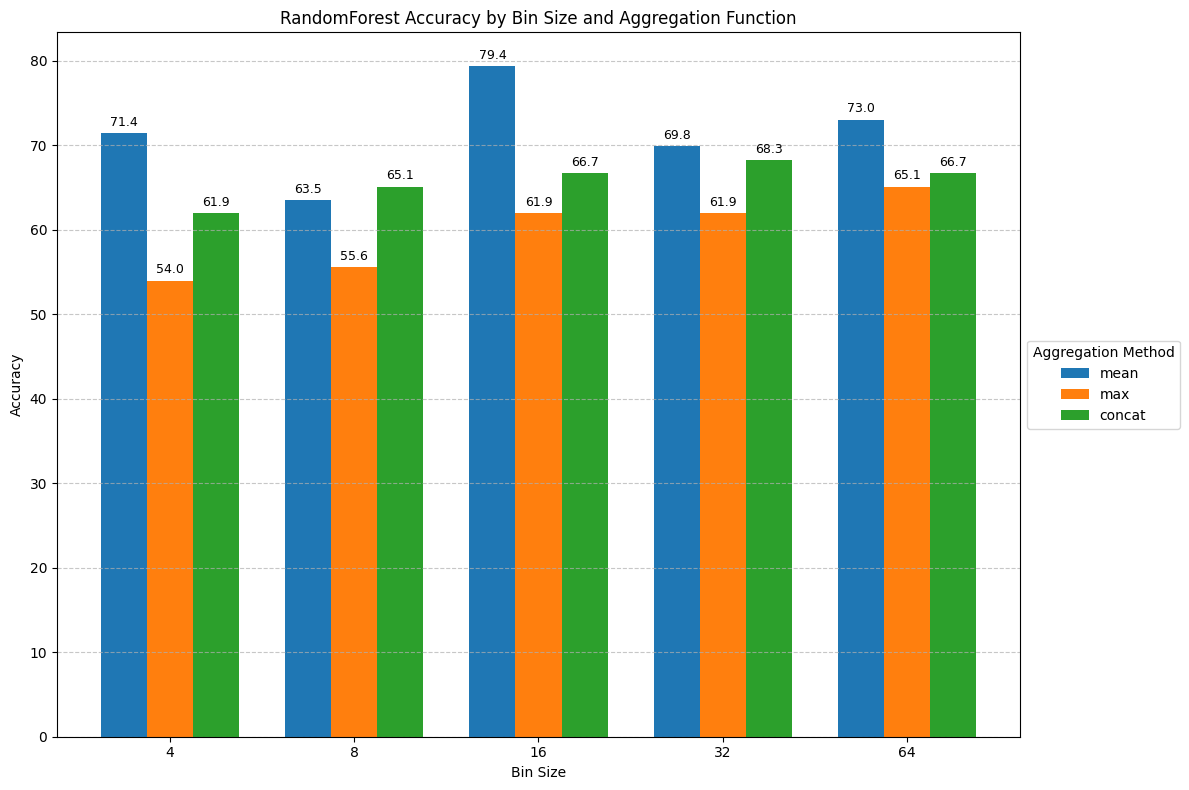

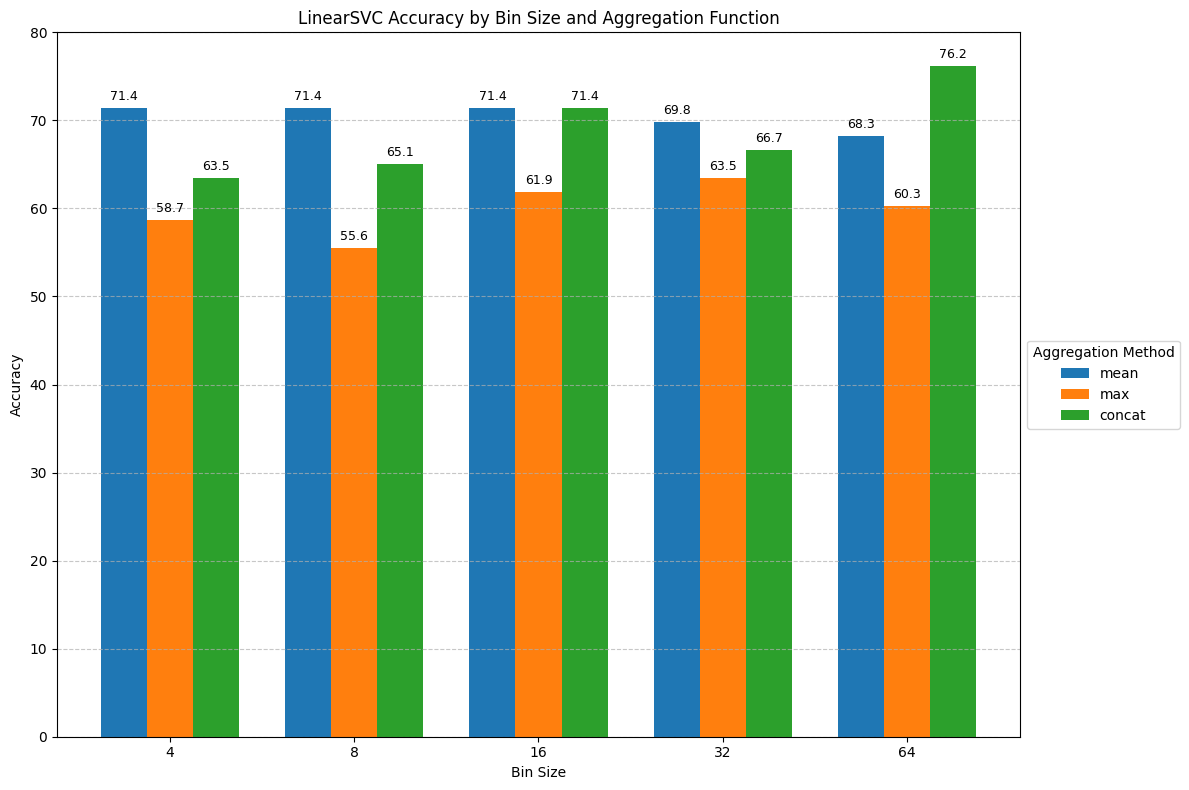

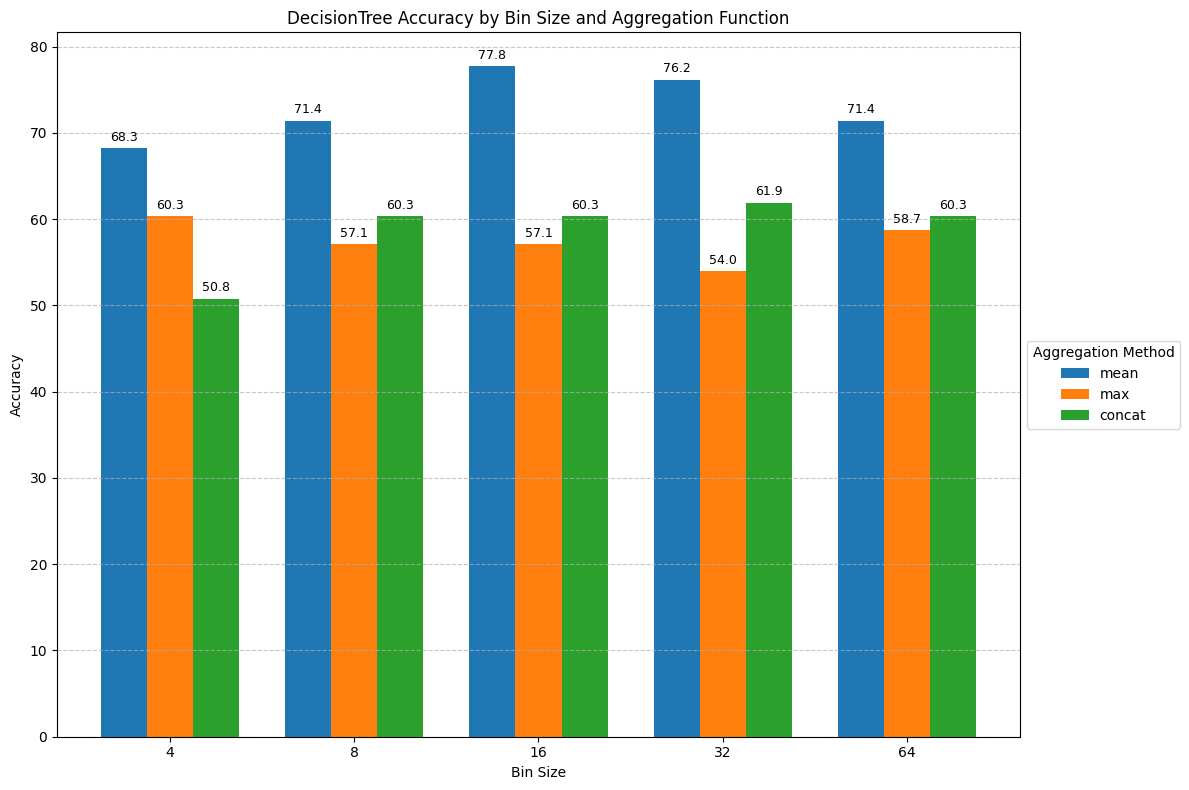

In [69]:
plot(accuracy, "Accuracy", ["RandomForest", "LinearSVC", "DecisionTree"])

#### Energy Consumption Raw

In [70]:
with open(os.path.join(current_dir, "energy_consumption\\regression\\predictions_dict.pkl"), "rb") as f:
    predicitons_dict = pickle.load(f)

with open(    os.path.join(current_dir, "energy_consumption\\regression\\features_dict.pkl"), "rb") as f:
    features_dict = pickle.load(f)

In [71]:
mae, rmse, _ = compute_metrics(predicitons_dict, features_dict, "regression")

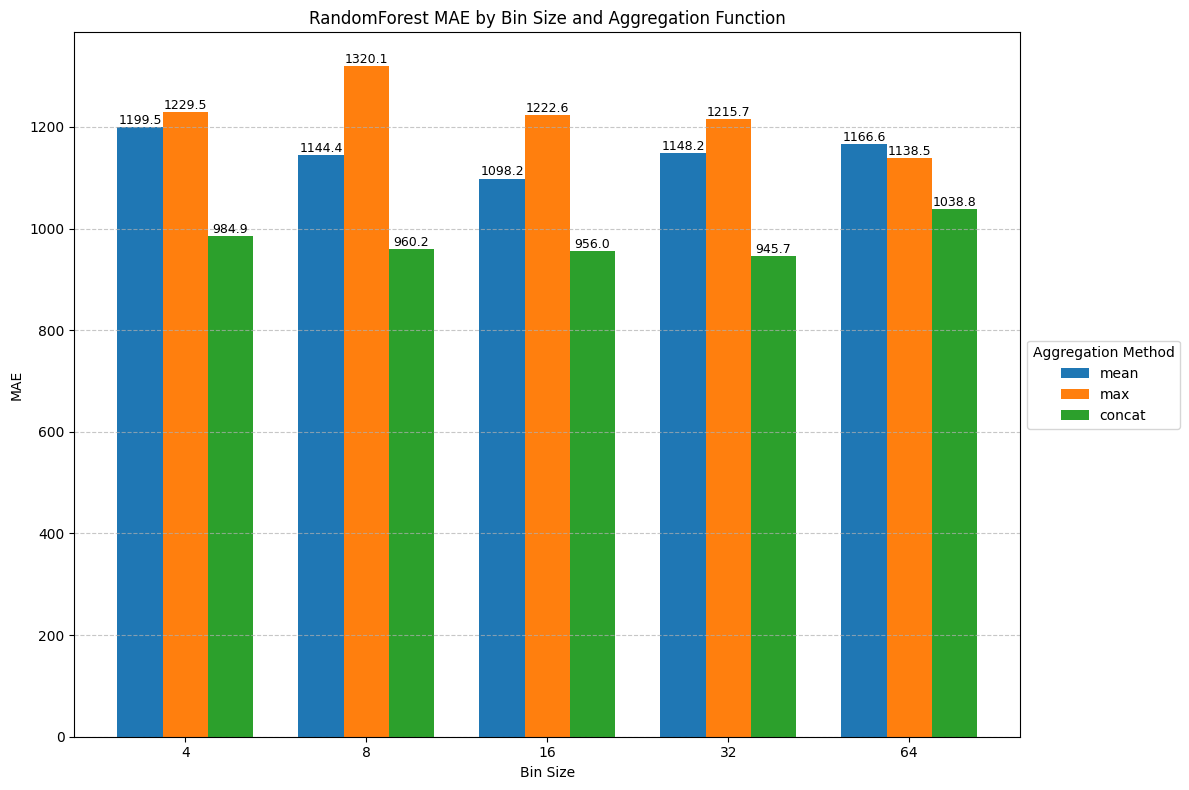

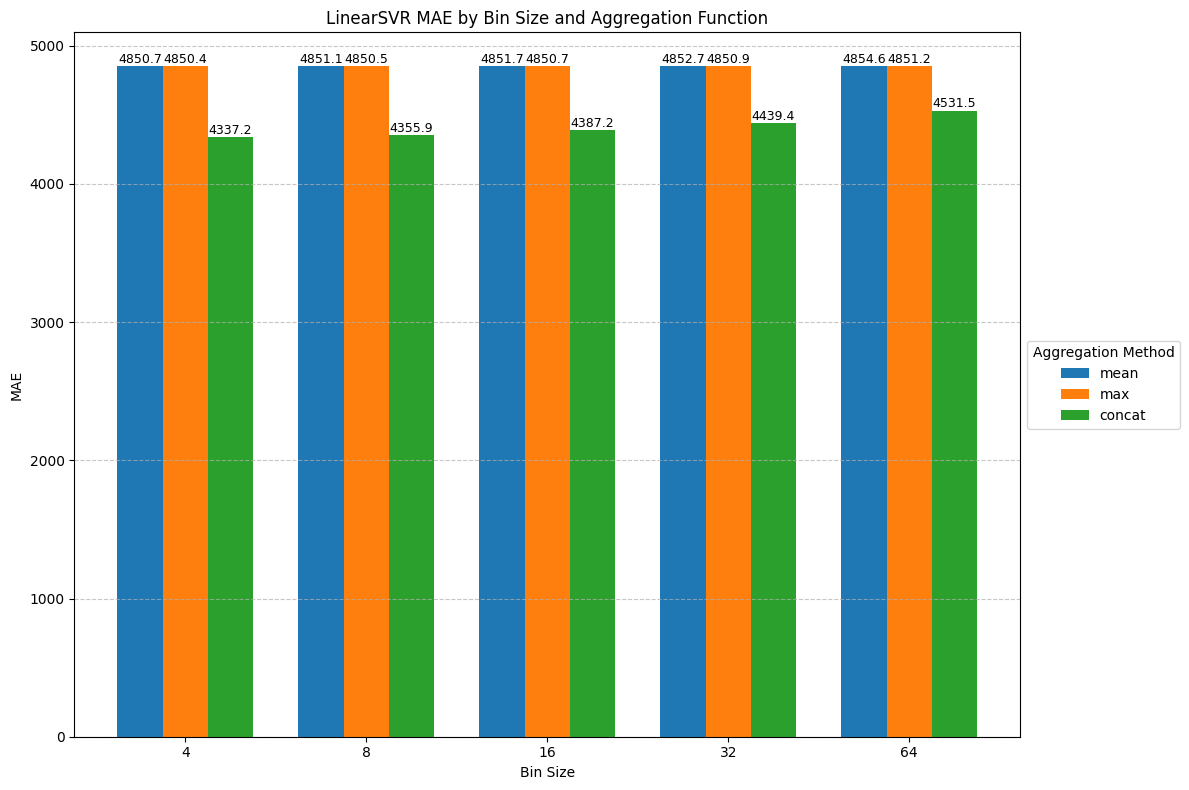

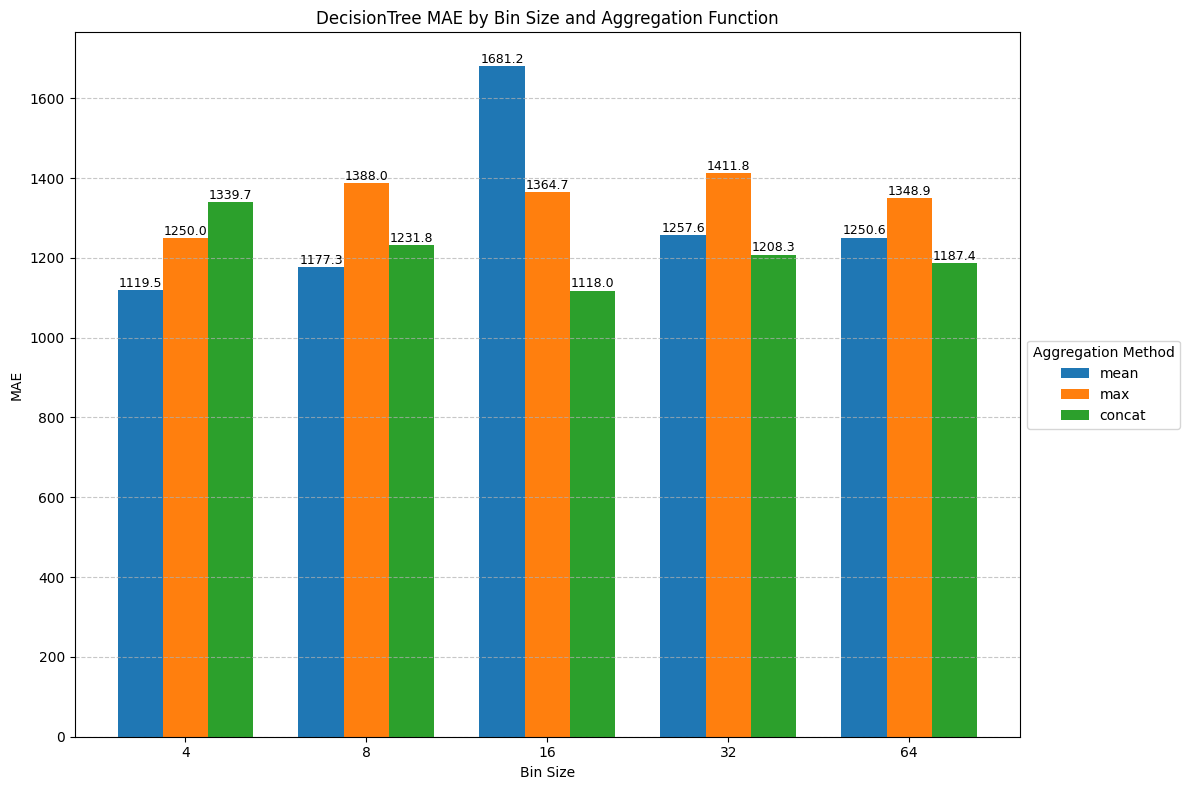

In [72]:
plot(mae, "MAE", ["RandomForest", "LinearSVR", "DecisionTree"])

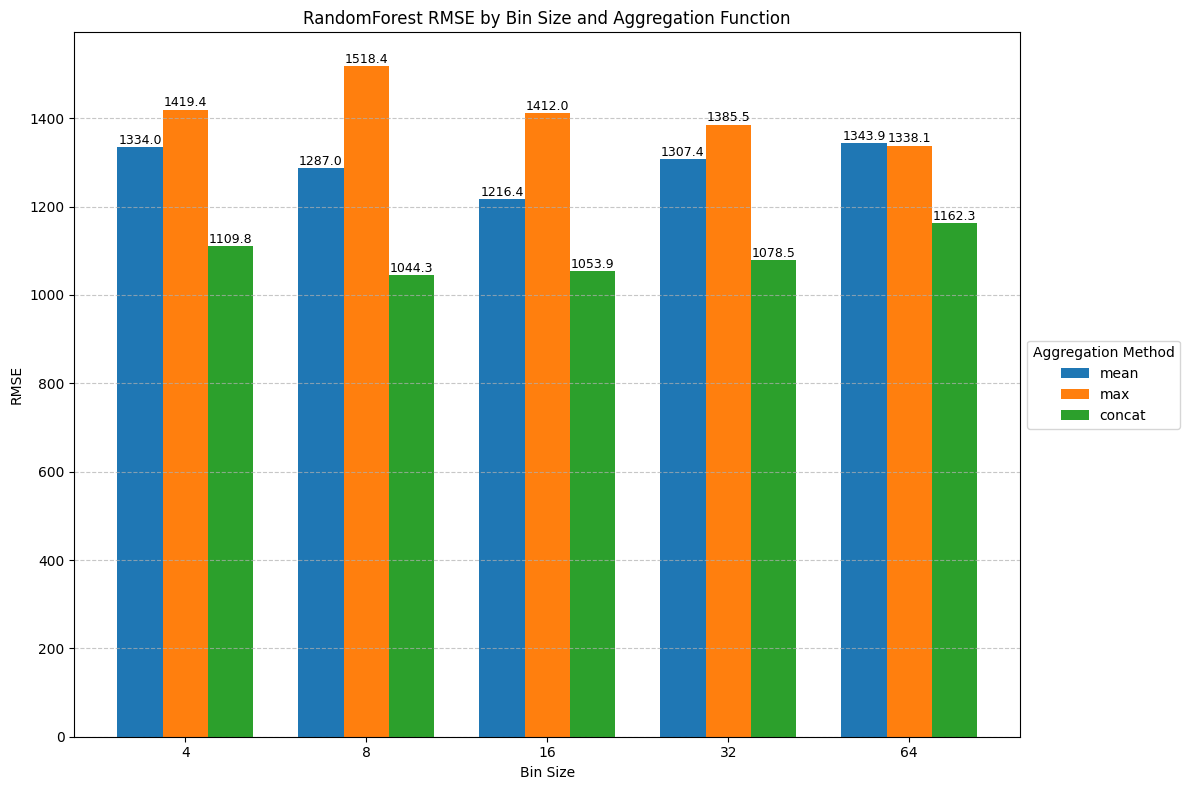

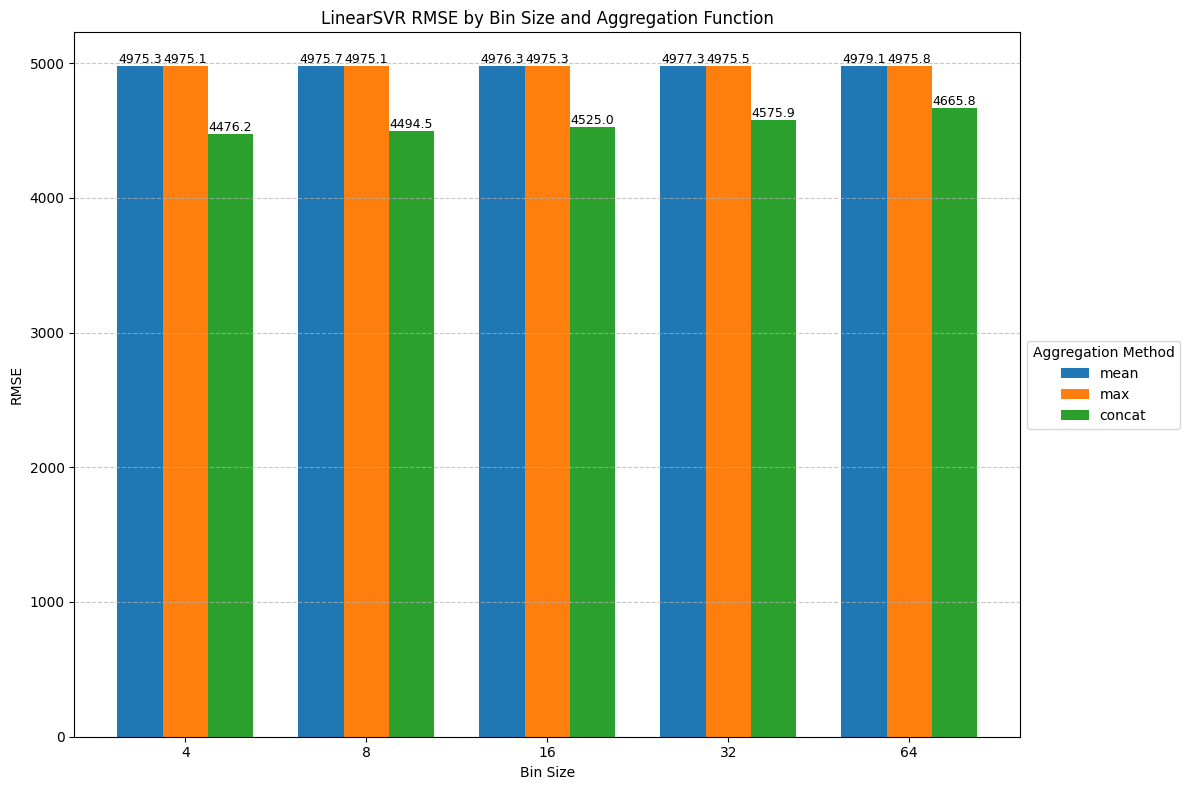

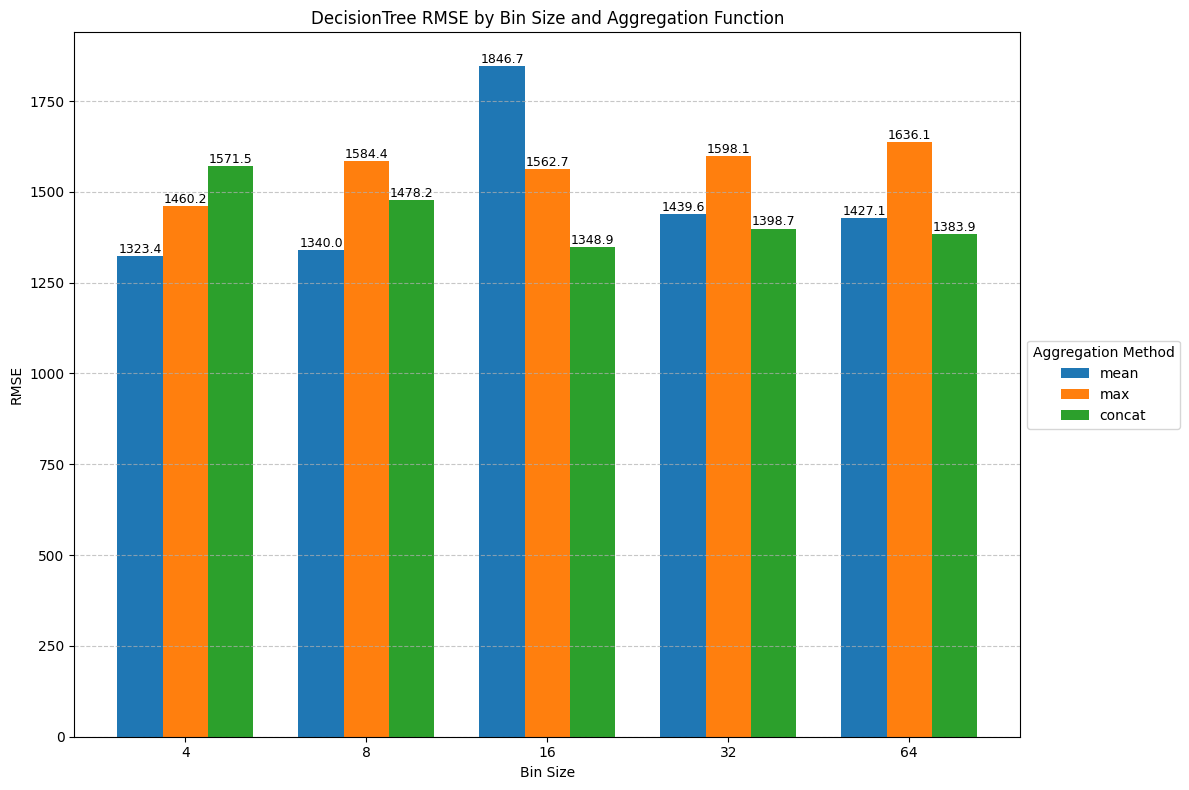

In [73]:
plot(rmse, "RMSE", ["RandomForest", "LinearSVR", "DecisionTree"])

#### CO2 Emission Binary

In [74]:
with open(os.path.join(current_dir, "CO2\\classification\\predictions_dict.pkl"), "rb") as f:
    predicitons_dict = pickle.load(f)

with open(os.path.join(current_dir, "CO2\\classification\\features_dict.pkl"), "rb") as f:
    features_dict = pickle.load(f)

In [75]:
_, _, accuracy = compute_metrics(predicitons_dict, features_dict, "classification")

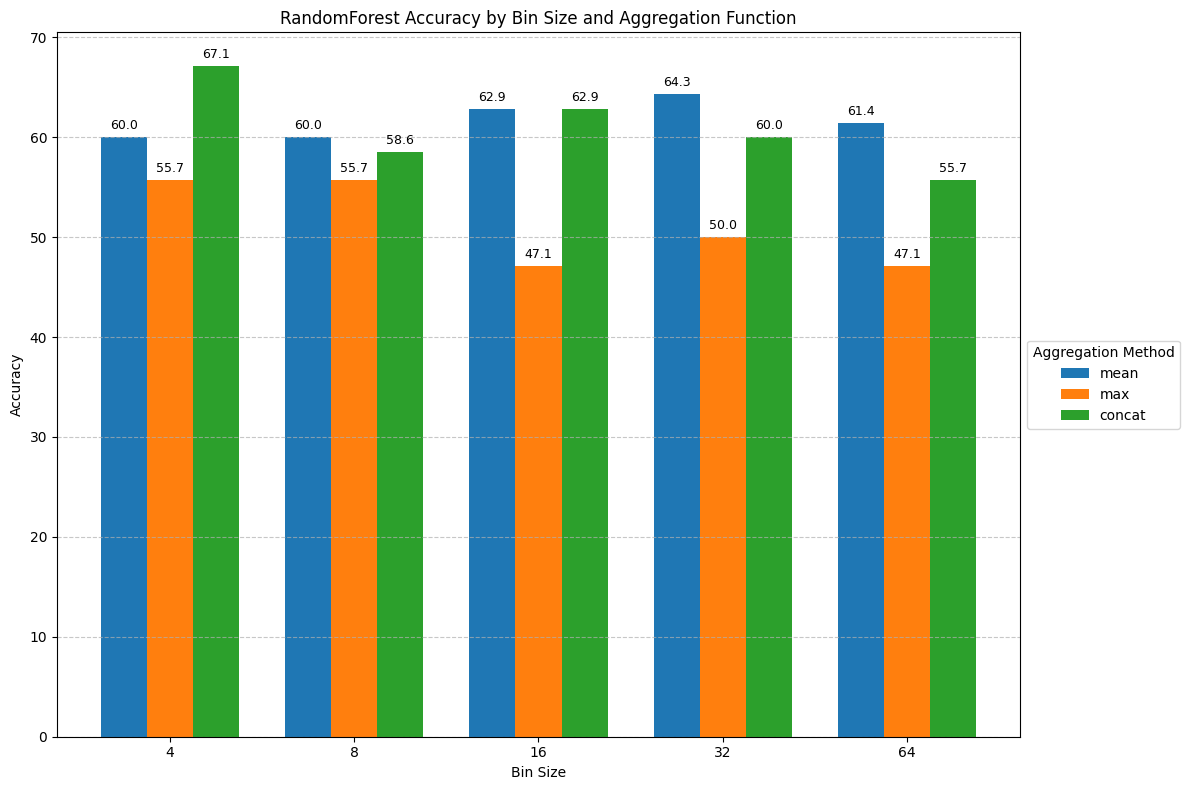

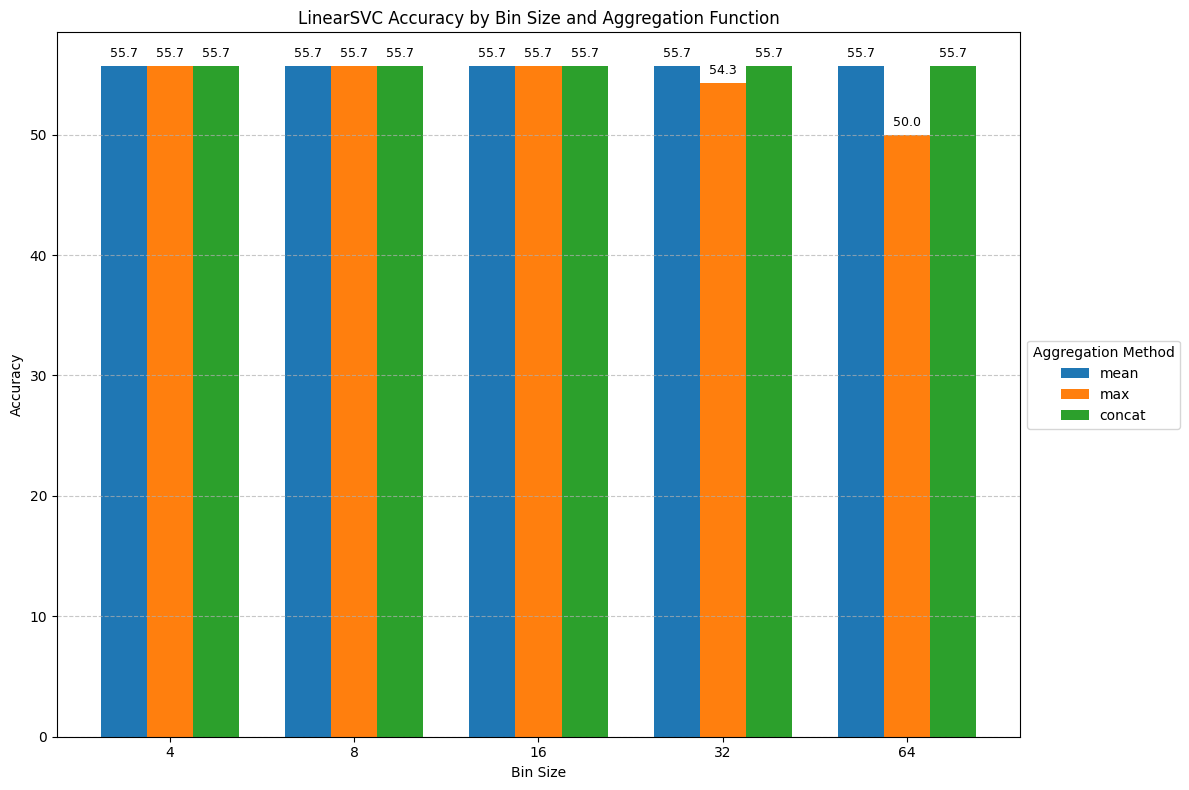

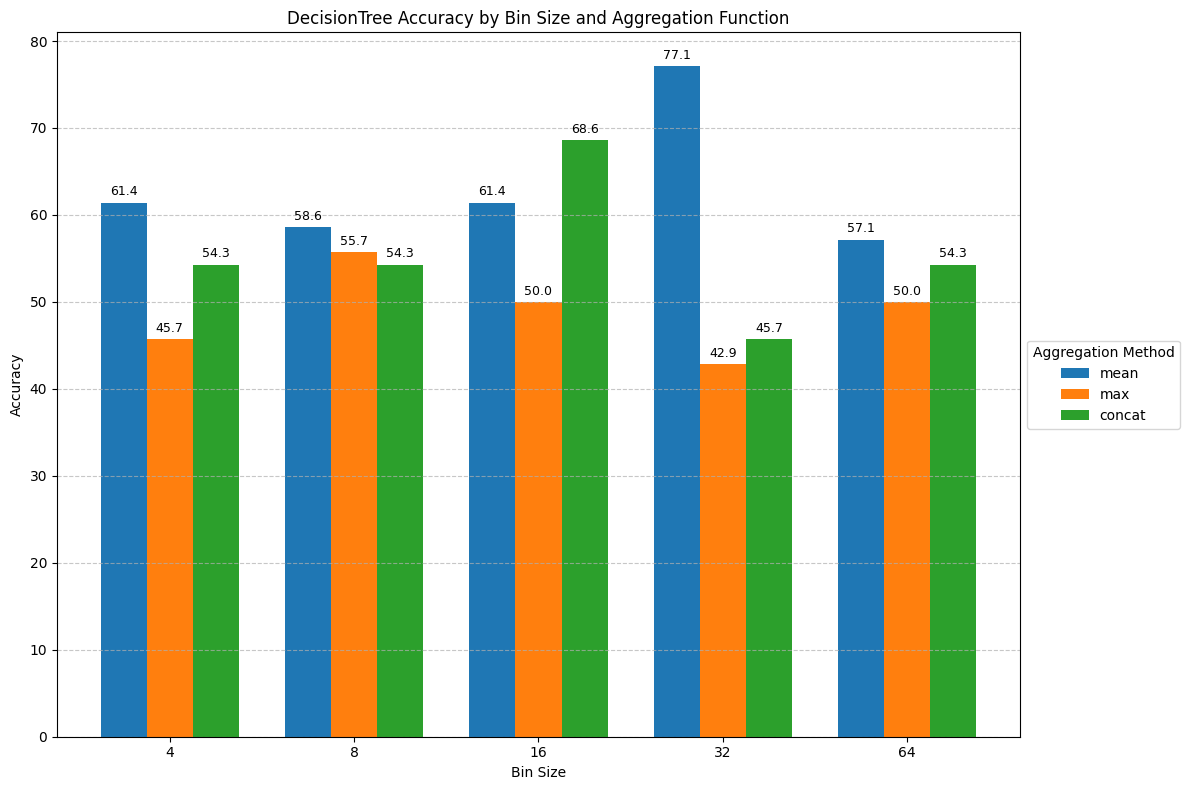

In [76]:
plot(accuracy, "Accuracy", ["RandomForest", "LinearSVC", "DecisionTree"])

#### CO2 Emission Raw

In [77]:
with open(os.path.join(current_dir, "CO2\\regression\\predictions_dict.pkl"), "rb") as f:
    predicitons_dict = pickle.load(f)

with open(os.path.join(current_dir, "CO2\\regression\\features_dict.pkl"), "rb") as f:
    features_dict = pickle.load(f)

In [78]:
mae, rmse, _ = compute_metrics(predicitons_dict, features_dict, "regression")

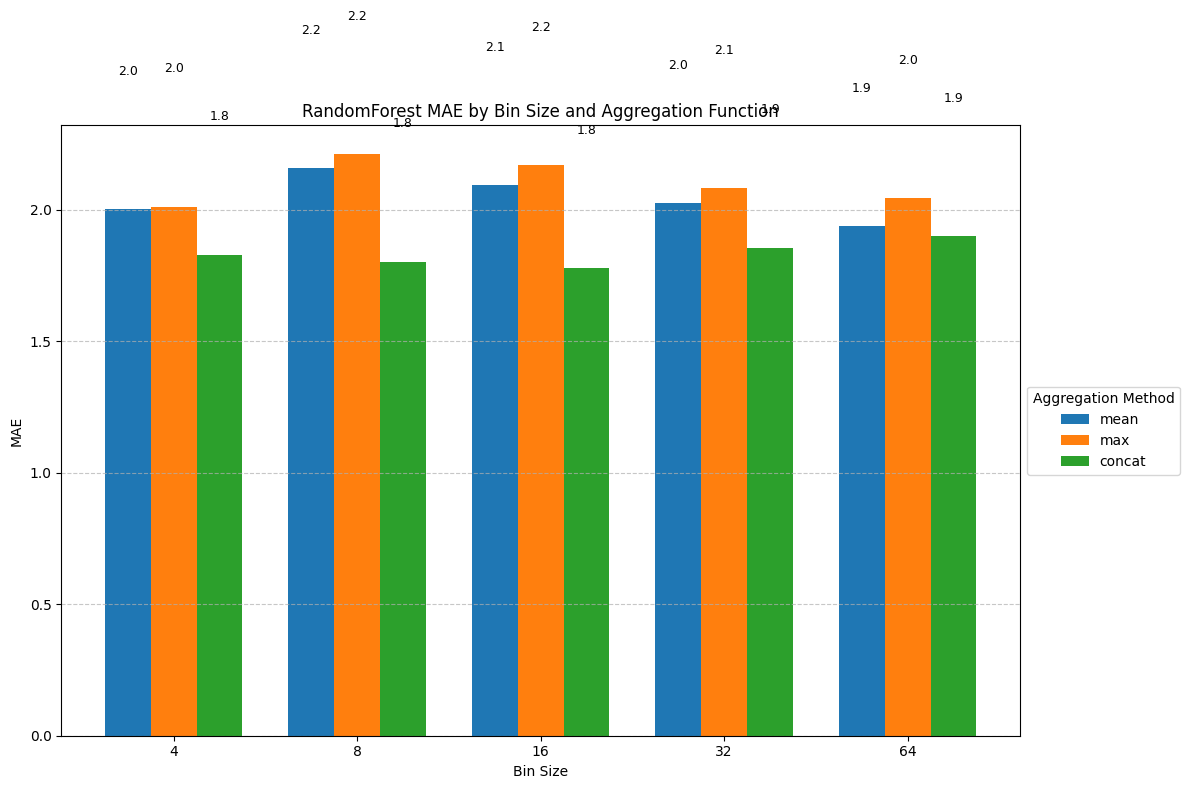

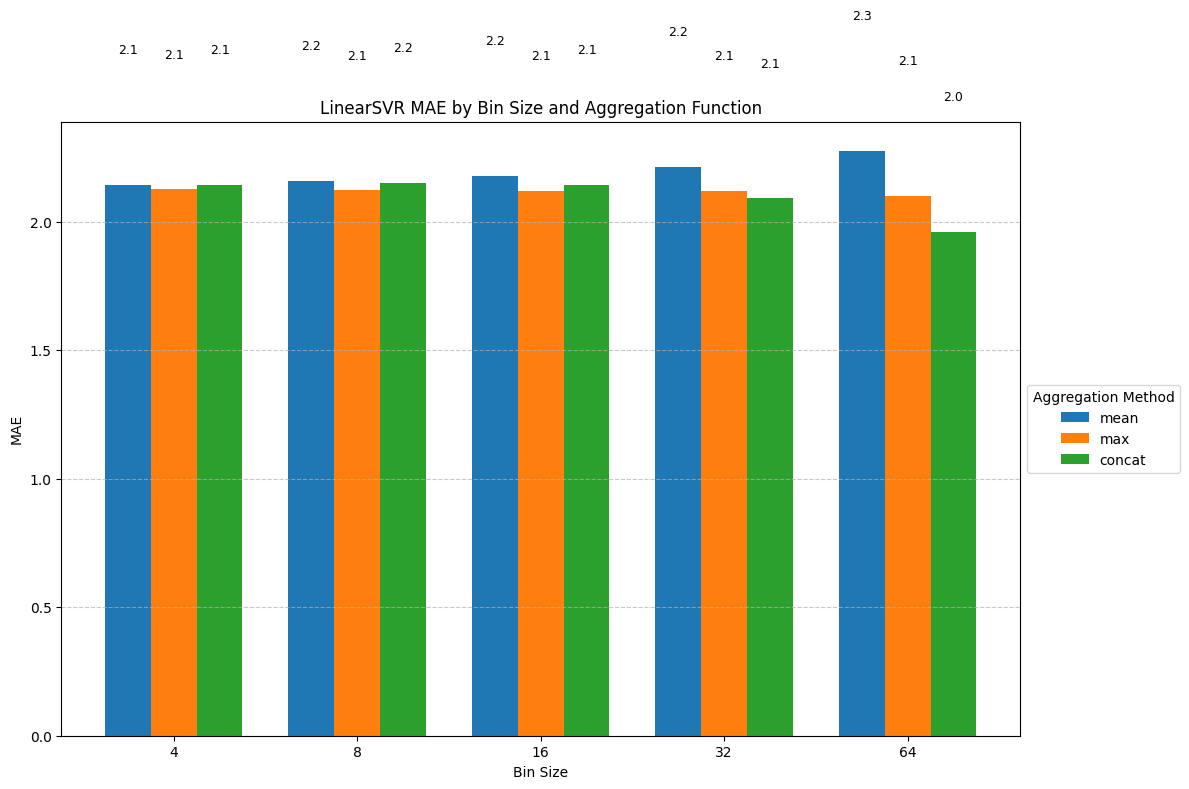

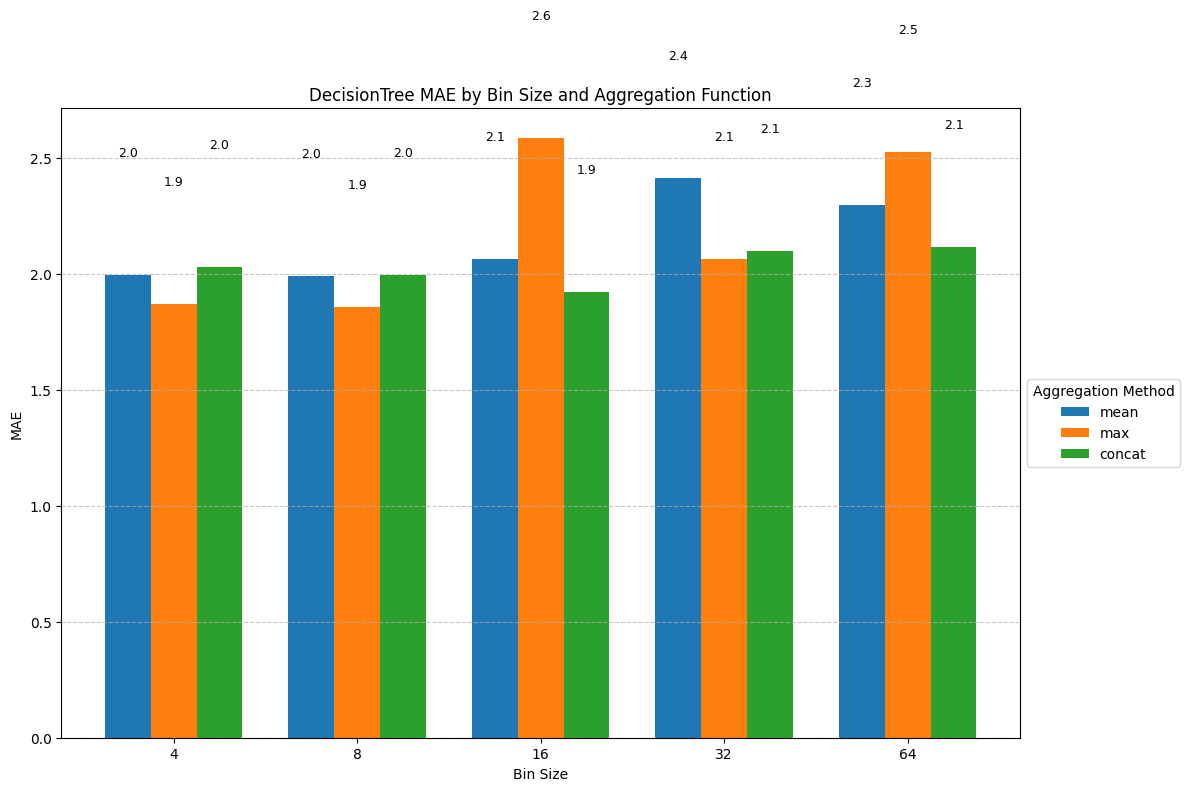

In [79]:
plot(mae, "MAE", ["RandomForest", "LinearSVR", "DecisionTree"])

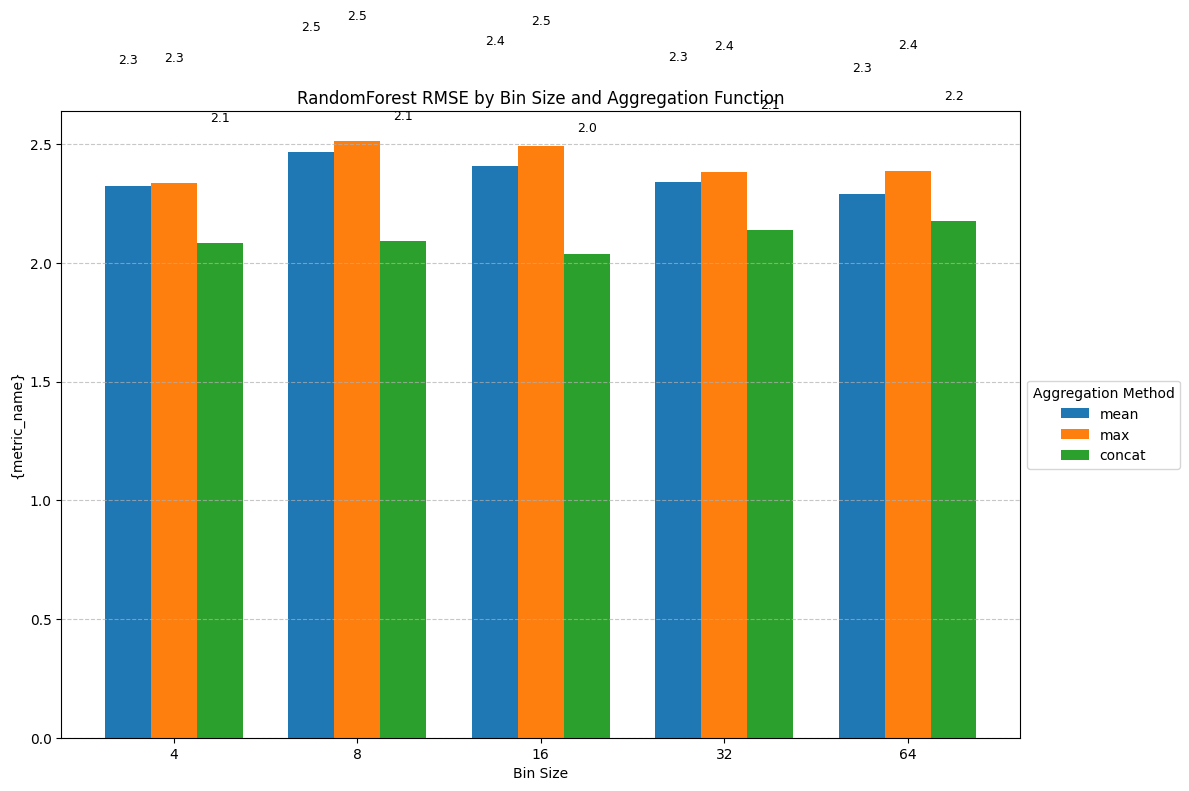

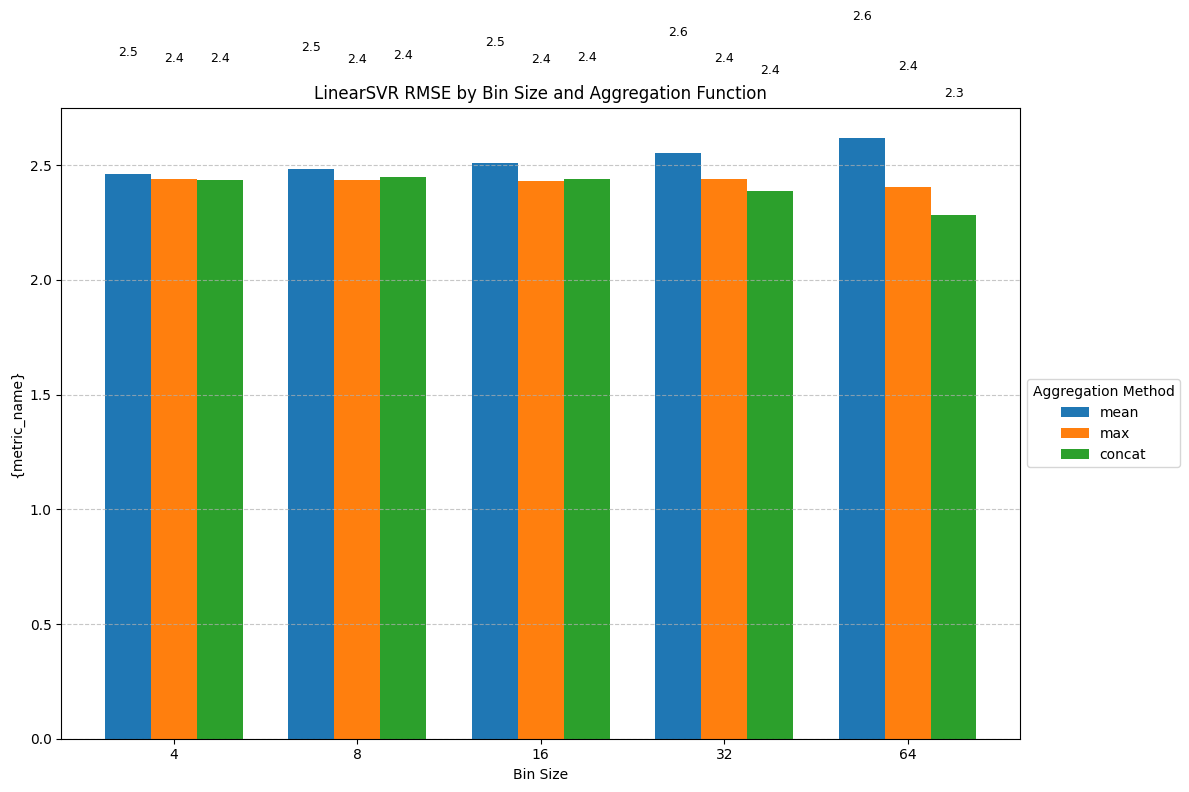

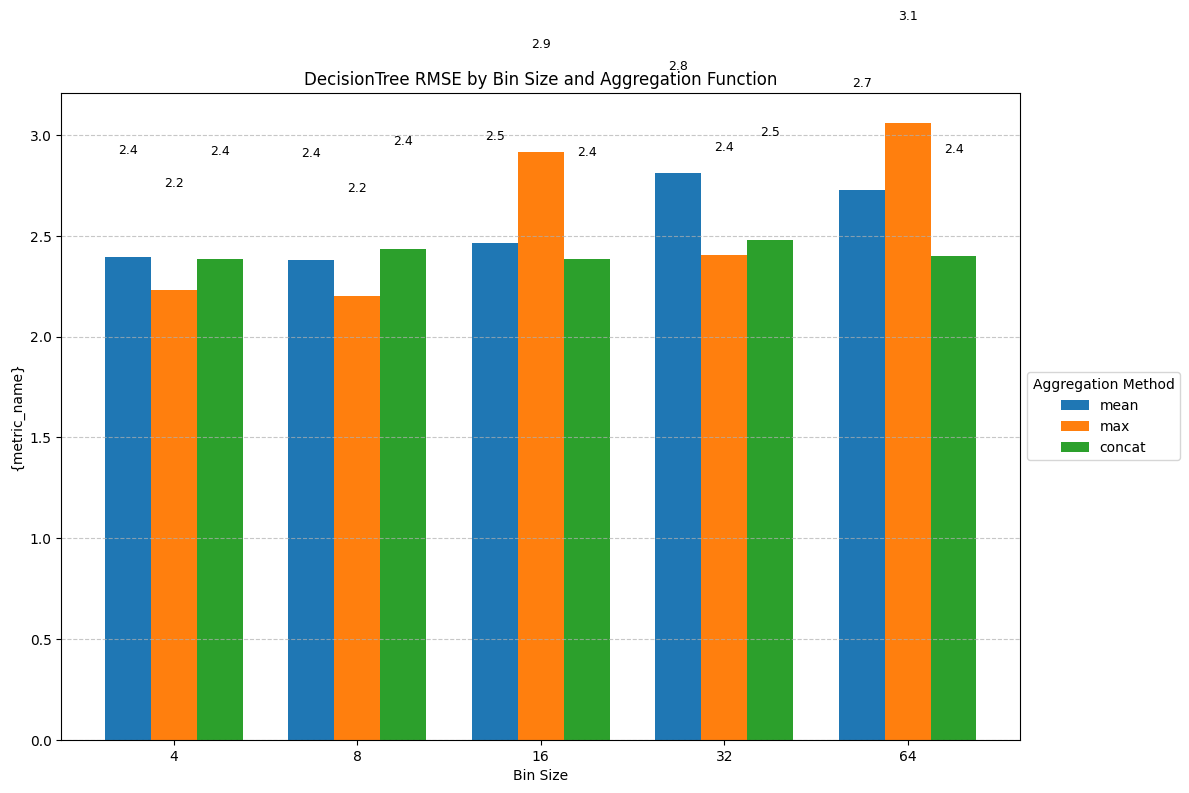

In [56]:
plot(rmse, "RMSE", ["RandomForest", "LinearSVR", "DecisionTree"])